# Fictitious Degradation Dataset

For each experiment and for each loading condition there are different degradation paths that have some common
characteristics which we should discover.


In [1]:
%load_ext autoreload
%autoreload
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
import numpy as np
import matplotlib.pyplot as pplot
tfd = tfp.distributions
from ipywidgets import FloatSlider, IntSlider, interact, interactive
import matplotlib.pyplot as pplot

from tensorflow.keras.layers import Input, Dense, Conv1D, GlobalAveragePooling1D, Dropout
from tensorflow.keras import Sequential,Model
import tensorflow.keras as keras


config = ConfigProto()
config.gpu_options.allow_growth = True
sess = InteractiveSession(config=config)

In [2]:
from utils import get_indices, data_from_experiment, get_graph_data, get_graph_data_multiple_experiments, get_multi_batch

In [3]:
## imports that are related to the fictitious dataset:

from datasets.fictitious_dataset import lhs_sample,transform_exp_data_to_random_signal_params,add_disturbances_in_signal,get_dat, make_experiments_3conditions

In [4]:
latent = make_experiments_3conditions(nexp_per_case=3)
help(make_experiments_3conditions)

Help on function make_experiments_3conditions in module datasets.fictitious_dataset:

make_experiments_3conditions(nexp_per_case=1, base_rate=1.0, rates_shift=-0.5, base_concentration=3.0, concentration_shifts=0.2)
    This function creates the latent variable for all cases. 
    
    When the cummulative latent variable passes a threshold failure occurs.
    The returned experiments correspond to 3 damage evolution regimes.
    These parameters were hand-picked so that the evolution is aligned with 
    some assumptions on the evolution of damage, have sufficient 
    variation to make the problem non-trivial, and have sufficient 
    variation between the 3 evolution cases.  In future implementations it may be 
    interesting to combine evolution regimes for representing arbitrary loading.



## Make the observation also contain some noise w.r.t. to the actual latent to make the problem more challenging

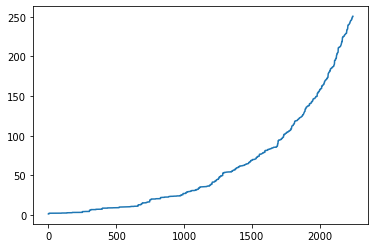

In [5]:
pplot.plot(latent[0]['latent_values']+np.random.randn())

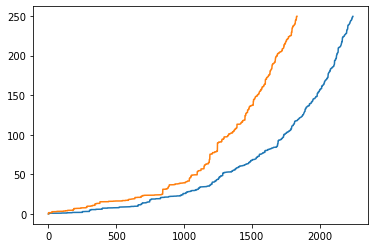

In [6]:
pplot.plot(latent[0]['latent_values'])
pplot.plot(latent[2]['latent_values'])


In [7]:
from datasets.fictitious_dataset import get_signal_for_segments

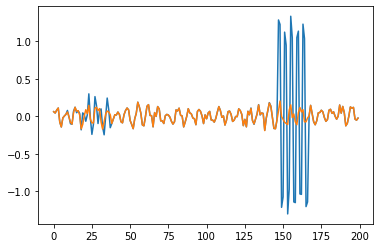

In [8]:
%autoreload
ss = get_signal_for_segments(latent[0]['latent_values'], speed = 150, rr=10)
pplot.plot(ss[-10,0:200])
pplot.plot(ss[10,0:200])


In [9]:
# for k in latent:
#     print(k)
#     pplot.plot(k['latent_values'])

In [10]:
latent = make_experiments_3conditions(nexp_per_case=10)
rand_dist = 5
for l  in latent[:]:
    l['latent_values'] = l['latent_values'] + np.abs(np.random.randn(*l['latent_values'].shape))*rand_dist
    

all_exp_dat = []
rr = 10
def reshape_ttf(v):
    if v.shape[0]%rr == 0:
        return np.mean(v.reshape([-1,rr]),1)
    else:
        return np.mean(v[:-(v.shape[0]%rr)].reshape([-1,rr]),1)
        
for d in latent:
    l = d['latent_values']
    ttf =d['ttf']
    
    y = reshape_ttf(ttf)
    case = d['case']
    speed_dict = {0:20, 1:25, 2:30}; # This is to superimpose a salient, yet irrelevant feature in the time-series.
                                     # Internally the network is expected to exploit this feature 
    if y.shape[0] == 0:
        break
    X = get_signal_for_segments(l, speed= speed_dict[case])
    eid = d['exp_index']

    exp_data = {
        "X" : X ,
        "eid" : (np.ones([X.shape[0],1]) * eid).astype(int),
        "y" : y,
        "case" : np.ones([X.shape[0],1]) * case
    }

    all_exp_dat.append(exp_data)

    

In [11]:
from datasets.fictitious_dataset import FictitiousDataset


In [12]:
fic=  FictitiousDataset(n_exp_per_case=5,pct_val_set=0.12,)
fic_test=  FictitiousDataset(n_exp_per_case=1,pct_val_set=0.12,)


Created random data for fictitious experiment.
training experiments: 12 , testing 3
Created random data for fictitious experiment.
training experiments: 0 , testing 3


In [13]:
def get_multi_batch_fictitious(*args, **kwargs):
    new_args = (args[0], fic)
    return get_multi_batch(*new_args, **kwargs)

def get_multi_batch_bootstrap_fictitious(*args,**kwargs):
    new_args = (args[0], fic)
    kwargs.update({"full_past_params" : {"min_idx_last_node" : 100 }})
    return get_multi_batch(*new_args,**kwargs)

In [14]:
# v = get_multi_batch_bootstrap_fictitious(4,fic, nseq_range = 648651568, nnodes = 20, min_spacing = 5)

In [15]:
# pplot.plot(np.hstack(v[0][0].node_times).T)

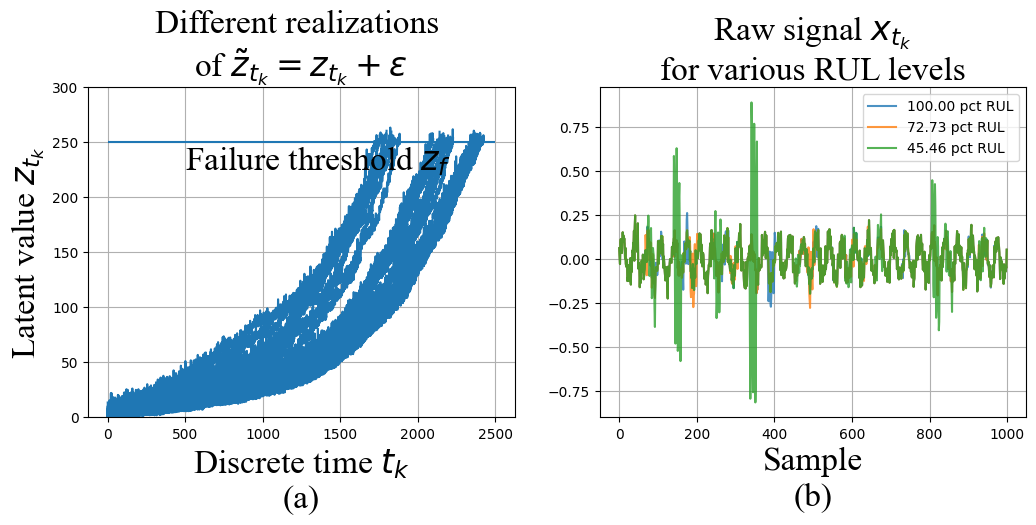

In [21]:
csfont = {'fontname':'Times New Roman','fontsize' : 24}

sc = 1.1
pplot.figure(figsize = (11*sc,5*sc), dpi = 100)
pplot.subplot(1,2,1)
for c in latent:
    pplot.plot(c['latent_values'],'C0')

pplot.ylim([0,300])
pplot.grid()
pplot.title("Different realizations \nof $ \~ z_{t_k} = z_{t_k} + \epsilon $ ",**csfont)
pplot.xlabel("Discrete time $t_k$\n(a)",**csfont)
pplot.ylabel("Latent value $z_{t_k}$",**csfont)
pplot.hlines(250,0,2500)
pplot.text(500,225,"Failure threshold $z_f$",**csfont)
pplot.subplot(1,2,2)

d = get_multi_batch(4,fic, nseq_range=100, nnodes = 5, min_spacing=2)


lab_= lambda x:  "%2.2f pct RUL"%(exp_data['y'][x]/np.max(exp_data['y'])*100) 
pplot.plot(exp_data['X'][0,:], label = lab_(0), alpha = 0.8)
pplot.plot(exp_data['X'][50,:], label = lab_(50), alpha = 0.8)
pplot.plot(exp_data['X'][100,:], label = lab_(100), alpha = 0.8)
pplot.grid()
pplot.xlabel("Sample\n(b)",**csfont)
pplot.legend()
pplot.title("Raw signal $x_{t_k}$ \nfor various RUL levels",**csfont)

pplot.subplots_adjust(top = 0.8, bottom = 0.2)
pplot.savefig("/home/charilaos/Workspace/ETH_WindmilRepositories/GraphNetCNN-paper/figures/fictitious_realizations.pdf")
!cp "/home/charilaos/Workspace/ETH_WindmilRepositories/GraphNetCNN-paper/figures/fictitious_realizations.pdf"  "/home/charilaos/Workspace/ETH_WindmilRepositories/GraphNetCNN-paper/to_mssp/figures/fictitious_realizations.pdf"

In [22]:
#!ls /home/charilaos/current/paper


In [23]:
help(pplot.subplots_adjust)

Help on function subplots_adjust in module matplotlib.pyplot:

subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
    Adjust the subplot layout parameters.
    
    Unset parameters are left unmodified; initial values are given by
    :rc:`figure.subplot.[name]`.
    
    Parameters
    ----------
    left : float, optional
        The position of the left edge of the subplots,
        as a fraction of the figure width.
    right : float, optional
        The position of the right edge of the subplots,
        as a fraction of the figure width.
    bottom : float, optional
        The position of the bottom edge of the subplots,
        as a fraction of the figure height.
    top : float, optional
        The position of the top edge of the subplots,
        as a fraction of the figure height.
    wspace : float, optional
        The width of the padding between subplots,
        as a fraction of the average axes width.
    hspace : float, optional


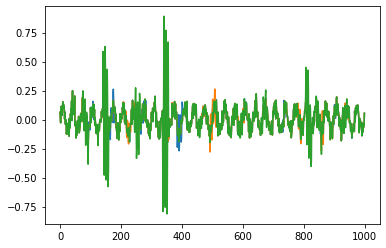

In [24]:
d = get_multi_batch(4,fic, nseq_range=100, nnodes = 5, min_spacing=2)
pplot.plot(exp_data['X'][0,:])
pplot.plot(exp_data['X'][10,:])
pplot.plot(exp_data['X'][100,:])


## Mini - graphnets
* **Edge**: Object keeping edge data - in this example dt and a latent output from the sender node.
* **Node**: Object keeping node data - in this example a latent variable (some function of observation and edge output).
* **Graph**: An object keeping edges/nodes corresponding to sequences of observations (and predictions?)
* **GraphNet**: An object defining how the computation happens on a graph object. It is a sequence of transformations and aggregations performed on edge and node states.

The information flowing through the graph may be better implemented in a sequential MC way. The nodes output samples or distributions, that are propagated by the edge to the time-instant corresponding to the receiver node. The edge aggregation function can be the application of Bayes rule in some way. 

## Utilities to make construction easier

## Classes for `Node` and `Edge` and `Graph`
These are classes encapsulating the attributes corresponding objects. Their behavior and the functions mutating them are implemented in a separate class (`GraphNet`) so that the graphNet can be evaluated with arbitrary graphs.

In [25]:
from minigraphnets import *

In [26]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
from graphnet_utils import GraphNetFunctionFactory
gn_tot = GraphNetFunctionFactory(channels_in =  1, 
                                 n_conv_blocks=2, 
                                 nfilts=10, 
                                 nfilts2=10,
                                 network_size_global = 30)

In [28]:
#gn_tot.load("/tmp/GraphNet_Fictitious")

In [29]:
gn_tot.make_graphnet_comp_blocks(fic.X[0].shape[0])


In [30]:
train_data = get_graph_data_multiple_experiments([0,2,3],fic.X, eid_oh_ = fic.eid_oh, yrem_norm_ = fic.yrem_norm ,
                                   nsamples_per_experiment = 50, nnodes = 10, min_spacing = 3, nseq_range=100)
gg_ = train_data[0][0]
predictions = train_data[0][1]

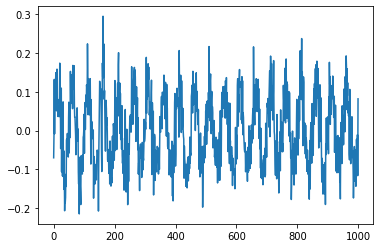

In [31]:
pplot.plot(train_data[0][0].nodes[0].node_attr_tensor[0,:,0])

In [32]:
if False:
    gg_.edges[-1].edge_tensor.flatten().shape, predictions
    #gg_.edges[1].edge_tensor-gg_.edges[0].edge_tensor
    pplot.plot(gg_.edges[0].edge_tensor.flatten(),predictions.flatten(),'.')

## A cleaner training loop (with some standard training tricks)

In [33]:
from utils_train import EarlyStopping, LRScheduler, LossLogger
learning_rate = 0.001;
opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)
loss_log = LossLogger()
early_stop = EarlyStopping(150,loss_log.loss_history['val_loss'])
lr_scheduler = LRScheduler(opt, epoch_decay = 40, decay_rate = 0.99)

<ipython-input-39-f18830941536>:64: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pplot.pcolor(xx,yy,colorscale_fn(v[:,ids_sort]), **kwargs)


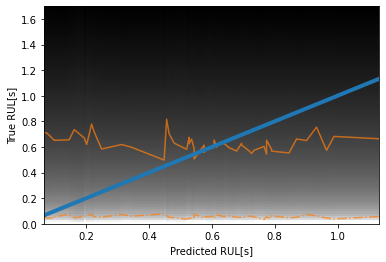

In [39]:
def eval_quantile(distr ,q, nsamples = 500):
    return np.quantile(distr.sample(nsamples),q,0)

def eval_graphnets(graph_in, iterations = None):
    return gn_tot.eval_graphnets(graph_in.copy(), iterations = iterations)

def plot_experiment_fit(graph_and_result_tuple, iterations =  iterations,
                        max_time = None,
                        colorscale_fn = lambda x : x, **kwargs):
    """
    returns v[:,ids_sort], q1,q2,qm, distribution, nll
    """
    #ind_exp = 0;
    y = graph_and_result_tuple[1]
    
    if max_time is None:
        max_time = np.max(y)*1.5
    t_probs= np.linspace(0,max_time,102)
    distribution = eval_graphnets(graph_and_result_tuple[0], iterations)
    nll = np.mean(-distribution.log_prob(y))
    v = distribution.prob(t_probs).numpy().T
    q1=eval_quantile(distribution,0.1)
    qm=eval_quantile(distribution,0.5)
    q2=eval_quantile(distribution,0.9)
    
    ids_sort = np.argsort(y.flatten());
    ysort = y[ids_sort.flatten()]
    xxvals = np.array([i for i in range(ysort.shape[0])])
    [xx,yy] = np.meshgrid(xxvals,t_probs)
    pplot.pcolor(xx,yy,colorscale_fn(v[:,ids_sort]), **kwargs)
    pplot.plot(xxvals,q1[ids_sort],'C1-.',alpha = 0.7)
    pplot.plot(xxvals,q2[ids_sort],'C1-.',alpha = 0.7)
    pplot.plot(xxvals,qm[ids_sort],'C1-', alpha = 0.7)
    pplot.plot(xxvals,y[ids_sort.flatten()],'C0-', linewidth = 4)
    
    pplot.xlabel("Sample")
    pplot.ylabel("RUL[s]")
    return v[:,ids_sort], q1,q2,qm, distribution, nll

def plot_experiment_fit_v2(graph_and_result_tuple, iterations =  None,
                        max_time = None,
                        colorscale_fn = lambda x : x, **kwargs):
    """
    returns v[:,ids_sort], q1,q2,qm, distribution, nll
    """
    #ind_exp = 0;
    y = graph_and_result_tuple[1]
    
    if max_time is None:
        max_time = np.max(y)*1.5
    
    t_probs= np.linspace(0,max_time,102)
    distribution = eval_graphnets(graph_and_result_tuple[0], iterations)
    nll = np.mean(-distribution.log_prob(y))
    v = distribution.prob(t_probs).numpy().T
    q1=eval_quantile(distribution,0.1)
    qm=eval_quantile(distribution,0.5)
    q2=eval_quantile(distribution,0.9)
    
    ids_sort = np.argsort(y.flatten());
    ysort = y[ids_sort.flatten()]
    xxvals = ysort ; #np.array([i for i in range(ysort.shape[0])])
    [xx,yy] = np.meshgrid(xxvals,t_probs)
    pplot.pcolor(xx,yy,colorscale_fn(v[:,ids_sort]), **kwargs)
    pplot.plot(xxvals,q1[ids_sort],'C1-.',alpha = 0.7)
    pplot.plot(xxvals,q2[ids_sort],'C1-.',alpha = 0.7)
    pplot.plot(xxvals,qm[ids_sort],'C1-', alpha = 0.7)
    pplot.plot(xxvals,y[ids_sort.flatten()],'C0-', linewidth = 4)
    pplot.ylim([0, max_time])
    pplot.xlabel("Predicted RUL[s]")
    pplot.ylabel("True RUL[s]")
    return v[:,ids_sort], q1,q2,qm, distribution, nll

n_iterations = 3
vs_, yy,q1,q2,d, nll  = plot_experiment_fit_v2( train_data[0], colorscale_fn=lambda x : x ** 0.5,  cmap = "gray", iterations = n_iterations)
#pplot.plot(q1)



In [40]:
res = gn_tot.bootstrap_eval_graphnets(train_data[0][0],n_bootstrap_samples=5, n_nodes_keep=3,return_final_node=False)



In [41]:
#pplot.hist(res.sample(10).numpy().flatten(),20)
#pplot.plot(train_data[0][0].nodes[-1].node_attr_tensor[:,:,0].T)

  0%|          | 0/200 [00:00<?, ?it/s]

nnodes: 1, seq_range 2 epoch: 0
loss: 11.601, val_loss 11.601
burn-in:  setting lr to 0.00000


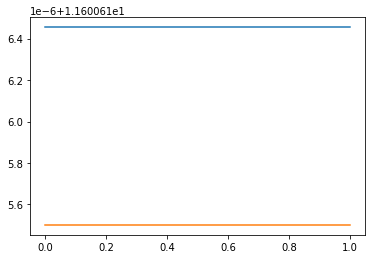

<ipython-input-39-f18830941536>:30: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pplot.pcolor(xx,yy,colorscale_fn(v[:,ids_sort]), **kwargs)


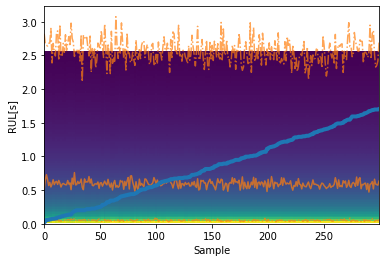

  0%|          | 1/200 [00:01<04:44,  1.43s/it]

nnodes: 2, seq_range 20 epoch: 1


  1%|          | 2/200 [00:02<04:00,  1.21s/it]

loss: 11.422, val_loss 11.422
burn-in:  setting lr to 0.00010
nnodes: 5, seq_range 150 epoch: 2


  2%|▏         | 3/200 [00:03<04:02,  1.23s/it]

loss: 6.289, val_loss 6.289
burn-in:  setting lr to 0.00020
nnodes: 10, seq_range 150 epoch: 3


  2%|▏         | 4/200 [00:05<04:48,  1.47s/it]

loss: 4.003, val_loss 4.003
burn-in:  setting lr to 0.00030
nnodes: 1, seq_range 2 epoch: 4


  2%|▎         | 5/200 [00:06<03:59,  1.23s/it]

loss: 11.327, val_loss 11.327
burn-in:  setting lr to 0.00040
nnodes: 2, seq_range 20 epoch: 5


  3%|▎         | 6/200 [00:07<03:44,  1.16s/it]

loss: 10.534, val_loss 10.534
burn-in:  setting lr to 0.00050
nnodes: 5, seq_range 150 epoch: 6


  4%|▎         | 7/200 [00:08<03:50,  1.20s/it]

loss: 3.109, val_loss 3.109
burn-in:  setting lr to 0.00060
nnodes: 10, seq_range 150 epoch: 7


  4%|▍         | 8/200 [00:10<04:25,  1.38s/it]

loss: -1.424, val_loss -1.424
burn-in:  setting lr to 0.00070
nnodes: 1, seq_range 2 epoch: 8


  4%|▍         | 9/200 [00:11<03:52,  1.21s/it]

loss: 9.844, val_loss 9.844
burn-in:  setting lr to 0.00080
nnodes: 2, seq_range 20 epoch: 9


  5%|▌         | 10/200 [00:12<03:42,  1.17s/it]

loss: 9.706, val_loss 9.706
burn-in:  setting lr to 0.00090
nnodes: 5, seq_range 150 epoch: 10
loss: 2.606, val_loss 2.606
burn-in:  setting lr to 0.00100


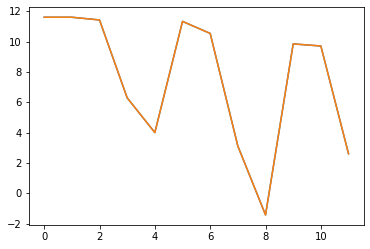

<ipython-input-39-f18830941536>:30: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pplot.pcolor(xx,yy,colorscale_fn(v[:,ids_sort]), **kwargs)


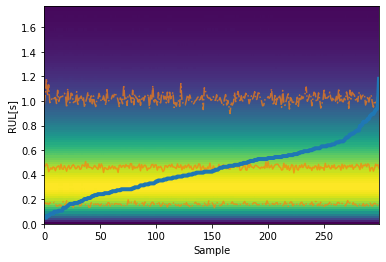

  6%|▌         | 11/200 [00:14<04:27,  1.42s/it]

nnodes: 10, seq_range 150 epoch: 11


  6%|▌         | 12/200 [00:15<04:37,  1.47s/it]

loss: -2.778, val_loss -2.778
nnodes: 1, seq_range 2 epoch: 12


  6%|▋         | 13/200 [00:16<03:55,  1.26s/it]

loss: 9.373, val_loss 9.373
nnodes: 2, seq_range 20 epoch: 13


  7%|▋         | 14/200 [00:17<03:41,  1.19s/it]

loss: 16.327, val_loss 16.327
nnodes: 5, seq_range 150 epoch: 14


  8%|▊         | 15/200 [00:18<03:39,  1.19s/it]

loss: 1.313, val_loss 1.313
nnodes: 10, seq_range 150 epoch: 15


  8%|▊         | 16/200 [00:20<04:02,  1.32s/it]

loss: -1.010, val_loss -1.010
nnodes: 1, seq_range 2 epoch: 16


  8%|▊         | 17/200 [00:21<03:32,  1.16s/it]

loss: 8.828, val_loss 8.828
nnodes: 2, seq_range 20 epoch: 17


  9%|▉         | 18/200 [00:22<03:23,  1.12s/it]

loss: 13.558, val_loss 13.558
nnodes: 5, seq_range 150 epoch: 18


 10%|▉         | 19/200 [00:23<03:27,  1.15s/it]

loss: 0.619, val_loss 0.619
nnodes: 10, seq_range 150 epoch: 19


 10%|█         | 20/200 [00:25<03:58,  1.32s/it]

loss: -0.778, val_loss -0.778
nnodes: 1, seq_range 2 epoch: 20
loss: 8.547, val_loss 8.547


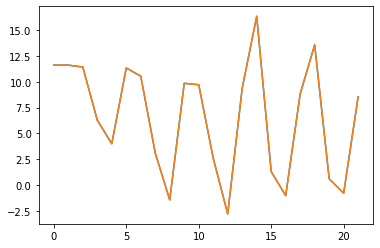

<ipython-input-39-f18830941536>:30: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pplot.pcolor(xx,yy,colorscale_fn(v[:,ids_sort]), **kwargs)


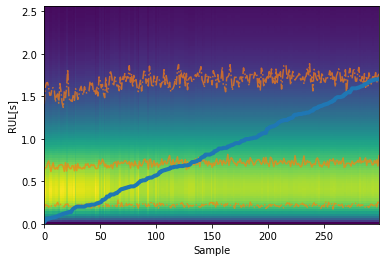

 10%|█         | 21/200 [00:26<04:01,  1.35s/it]

nnodes: 2, seq_range 20 epoch: 21


 11%|█         | 22/200 [00:27<03:42,  1.25s/it]

loss: 12.171, val_loss 12.171
nnodes: 5, seq_range 150 epoch: 22


 12%|█▏        | 23/200 [00:28<03:38,  1.23s/it]

loss: 0.203, val_loss 0.203
nnodes: 10, seq_range 150 epoch: 23


 12%|█▏        | 24/200 [00:30<03:55,  1.34s/it]

loss: -1.063, val_loss -1.063
nnodes: 1, seq_range 2 epoch: 24


 12%|█▎        | 25/200 [00:31<03:26,  1.18s/it]

loss: 8.113, val_loss 8.113
nnodes: 2, seq_range 20 epoch: 25


 13%|█▎        | 26/200 [00:32<03:17,  1.13s/it]

loss: 10.050, val_loss 10.050
nnodes: 5, seq_range 150 epoch: 26


 14%|█▎        | 27/200 [00:33<03:19,  1.15s/it]

loss: 0.983, val_loss 0.983
nnodes: 10, seq_range 150 epoch: 27


 14%|█▍        | 28/200 [00:35<03:46,  1.32s/it]

loss: -2.248, val_loss -2.248
nnodes: 1, seq_range 2 epoch: 28


 14%|█▍        | 29/200 [00:36<03:19,  1.16s/it]

loss: 10.224, val_loss 10.224
nnodes: 2, seq_range 20 epoch: 29


 15%|█▌        | 30/200 [00:37<03:10,  1.12s/it]

loss: 9.052, val_loss 9.052
nnodes: 5, seq_range 150 epoch: 30
loss: 2.004, val_loss 2.004


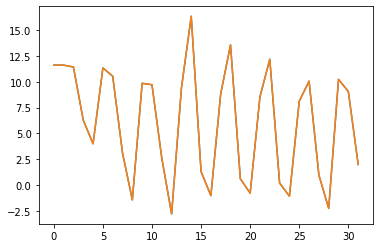

<ipython-input-39-f18830941536>:30: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pplot.pcolor(xx,yy,colorscale_fn(v[:,ids_sort]), **kwargs)


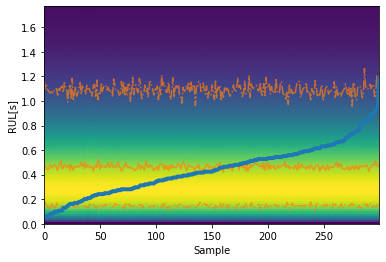

 16%|█▌        | 31/200 [00:38<03:37,  1.29s/it]

nnodes: 10, seq_range 150 epoch: 31


 16%|█▌        | 32/200 [00:40<04:02,  1.44s/it]

loss: -2.083, val_loss -2.083
nnodes: 1, seq_range 2 epoch: 32


 16%|█▋        | 33/200 [00:41<03:28,  1.25s/it]

loss: 11.338, val_loss 11.338
nnodes: 2, seq_range 20 epoch: 33


 17%|█▋        | 34/200 [00:42<03:14,  1.17s/it]

loss: 9.414, val_loss 9.414
nnodes: 5, seq_range 150 epoch: 34


 18%|█▊        | 35/200 [00:43<03:12,  1.17s/it]

loss: 1.980, val_loss 1.980
nnodes: 10, seq_range 150 epoch: 35


 18%|█▊        | 36/200 [00:45<03:34,  1.31s/it]

loss: -1.840, val_loss -1.840
nnodes: 1, seq_range 2 epoch: 36


 18%|█▊        | 37/200 [00:45<03:06,  1.14s/it]

loss: 8.578, val_loss 8.578
nnodes: 2, seq_range 20 epoch: 37


 19%|█▉        | 38/200 [00:46<03:02,  1.13s/it]

loss: 11.590, val_loss 11.590
nnodes: 5, seq_range 150 epoch: 38


 20%|█▉        | 39/200 [00:48<03:04,  1.15s/it]

loss: 2.181, val_loss 2.181
nnodes: 10, seq_range 150 epoch: 39


 20%|██        | 40/200 [00:49<03:27,  1.30s/it]

loss: -2.509, val_loss -2.509
nnodes: 1, seq_range 2 epoch: 40
loss: 9.318, val_loss 9.318
lr_decay: setting lr to 0.00099


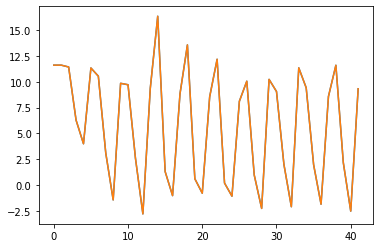

<ipython-input-39-f18830941536>:30: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pplot.pcolor(xx,yy,colorscale_fn(v[:,ids_sort]), **kwargs)


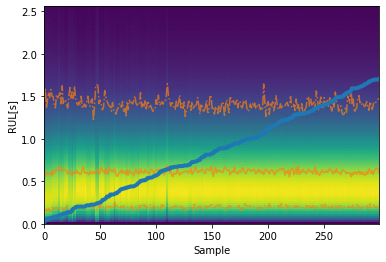

 20%|██        | 41/200 [00:51<03:34,  1.35s/it]

nnodes: 2, seq_range 20 epoch: 41


 21%|██        | 42/200 [00:52<03:20,  1.27s/it]

loss: 10.921, val_loss 10.921
lr_decay: setting lr to 0.00098
nnodes: 5, seq_range 150 epoch: 42


 22%|██▏       | 43/200 [00:53<03:14,  1.24s/it]

loss: -0.094, val_loss -0.094
lr_decay: setting lr to 0.00097
nnodes: 10, seq_range 150 epoch: 43


 22%|██▏       | 44/200 [00:55<03:26,  1.32s/it]

loss: -2.960, val_loss -2.960
lr_decay: setting lr to 0.00096
nnodes: 1, seq_range 2 epoch: 44


 22%|██▎       | 45/200 [00:55<03:00,  1.16s/it]

loss: 5.819, val_loss 5.819
lr_decay: setting lr to 0.00095
nnodes: 2, seq_range 20 epoch: 45


 23%|██▎       | 46/200 [00:56<02:52,  1.12s/it]

loss: 7.220, val_loss 7.220
lr_decay: setting lr to 0.00094
nnodes: 5, seq_range 150 epoch: 46


 24%|██▎       | 47/200 [00:58<02:53,  1.13s/it]

loss: -0.884, val_loss -0.884
lr_decay: setting lr to 0.00093
nnodes: 10, seq_range 150 epoch: 47


 24%|██▍       | 48/200 [00:59<03:12,  1.27s/it]

loss: -3.300, val_loss -3.300
lr_decay: setting lr to 0.00092
nnodes: 1, seq_range 2 epoch: 48


 24%|██▍       | 49/200 [01:00<02:52,  1.14s/it]

loss: 4.074, val_loss 4.074
lr_decay: setting lr to 0.00091
nnodes: 2, seq_range 20 epoch: 49


 25%|██▌       | 50/200 [01:01<02:48,  1.12s/it]

loss: 5.809, val_loss 5.809
lr_decay: setting lr to 0.00090
nnodes: 5, seq_range 150 epoch: 50
loss: -1.620, val_loss -1.620
lr_decay: setting lr to 0.00090


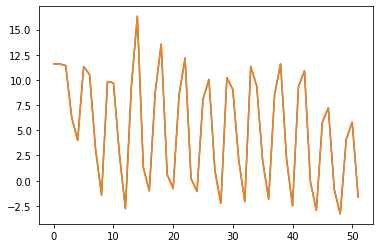

<ipython-input-39-f18830941536>:30: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pplot.pcolor(xx,yy,colorscale_fn(v[:,ids_sort]), **kwargs)


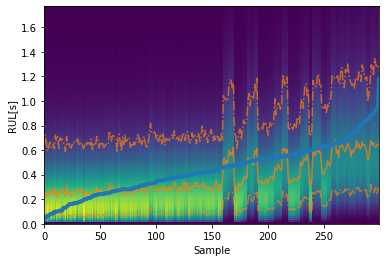

 26%|██▌       | 51/200 [01:03<03:14,  1.31s/it]

nnodes: 10, seq_range 150 epoch: 51


 26%|██▌       | 52/200 [01:05<03:40,  1.49s/it]

loss: -4.883, val_loss -4.883
lr_decay: setting lr to 0.00089
nnodes: 1, seq_range 2 epoch: 52


 26%|██▋       | 53/200 [01:05<03:06,  1.27s/it]

loss: 3.125, val_loss 3.125
lr_decay: setting lr to 0.00088
nnodes: 2, seq_range 20 epoch: 53


 27%|██▋       | 54/200 [01:06<02:51,  1.18s/it]

loss: 4.320, val_loss 4.320
lr_decay: setting lr to 0.00087
nnodes: 5, seq_range 150 epoch: 54


 28%|██▊       | 55/200 [01:08<02:52,  1.19s/it]

loss: -3.115, val_loss -3.115
lr_decay: setting lr to 0.00086
nnodes: 10, seq_range 150 epoch: 55


 28%|██▊       | 56/200 [01:09<03:13,  1.34s/it]

loss: -5.962, val_loss -5.962
lr_decay: setting lr to 0.00085
nnodes: 1, seq_range 2 epoch: 56


 28%|██▊       | 57/200 [01:10<02:49,  1.19s/it]

loss: 2.091, val_loss 2.091
lr_decay: setting lr to 0.00084
nnodes: 2, seq_range 20 epoch: 57


 29%|██▉       | 58/200 [01:11<02:39,  1.12s/it]

loss: 2.907, val_loss 2.907
lr_decay: setting lr to 0.00083
nnodes: 5, seq_range 150 epoch: 58


 30%|██▉       | 59/200 [01:12<02:38,  1.12s/it]

loss: -3.900, val_loss -3.900
lr_decay: setting lr to 0.00083
nnodes: 10, seq_range 150 epoch: 59


 30%|███       | 60/200 [01:14<02:53,  1.24s/it]

loss: -6.920, val_loss -6.920
lr_decay: setting lr to 0.00082
nnodes: 1, seq_range 2 epoch: 60
loss: 1.500, val_loss 1.500
lr_decay: setting lr to 0.00081


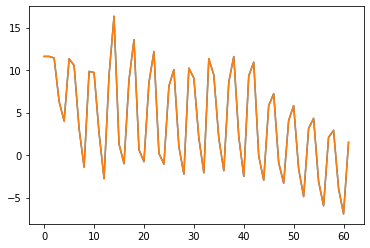

<ipython-input-39-f18830941536>:30: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pplot.pcolor(xx,yy,colorscale_fn(v[:,ids_sort]), **kwargs)


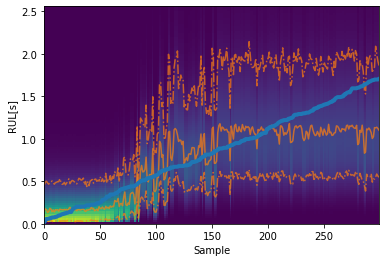

 30%|███       | 61/200 [01:15<02:49,  1.22s/it]

nnodes: 2, seq_range 20 epoch: 61


 31%|███       | 62/200 [01:16<02:41,  1.17s/it]

loss: 3.587, val_loss 3.587
lr_decay: setting lr to 0.00080
nnodes: 5, seq_range 150 epoch: 62


 32%|███▏      | 63/200 [01:17<02:49,  1.24s/it]

loss: -4.149, val_loss -4.149
lr_decay: setting lr to 0.00079
nnodes: 10, seq_range 150 epoch: 63


 32%|███▏      | 64/200 [01:19<03:07,  1.38s/it]

loss: -7.378, val_loss -7.378
lr_decay: setting lr to 0.00079
nnodes: 1, seq_range 2 epoch: 64


 32%|███▎      | 65/200 [01:20<02:40,  1.19s/it]

loss: 1.076, val_loss 1.076
lr_decay: setting lr to 0.00078
nnodes: 2, seq_range 20 epoch: 65


 33%|███▎      | 66/200 [01:21<02:29,  1.12s/it]

loss: 2.299, val_loss 2.299
lr_decay: setting lr to 0.00077
nnodes: 5, seq_range 150 epoch: 66


 34%|███▎      | 67/200 [01:22<02:29,  1.12s/it]

loss: -4.979, val_loss -4.979
lr_decay: setting lr to 0.00076
nnodes: 10, seq_range 150 epoch: 67


 34%|███▍      | 68/200 [01:23<02:45,  1.26s/it]

loss: -7.771, val_loss -7.771
lr_decay: setting lr to 0.00075
nnodes: 1, seq_range 2 epoch: 68


 34%|███▍      | 69/200 [01:24<02:25,  1.11s/it]

loss: 0.797, val_loss 0.797
lr_decay: setting lr to 0.00075
nnodes: 2, seq_range 20 epoch: 69


 35%|███▌      | 70/200 [01:25<02:17,  1.06s/it]

loss: 1.934, val_loss 1.934
lr_decay: setting lr to 0.00074
nnodes: 5, seq_range 150 epoch: 70
loss: -5.444, val_loss -5.444
lr_decay: setting lr to 0.00073


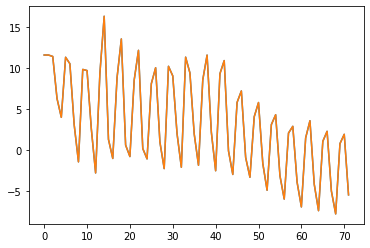

<ipython-input-39-f18830941536>:30: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pplot.pcolor(xx,yy,colorscale_fn(v[:,ids_sort]), **kwargs)


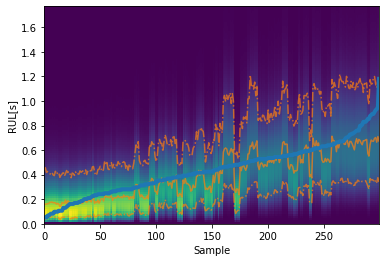

 36%|███▌      | 71/200 [01:27<02:42,  1.26s/it]

nnodes: 10, seq_range 150 epoch: 71


 36%|███▌      | 72/200 [01:29<03:01,  1.42s/it]

loss: -8.133, val_loss -8.133
lr_decay: setting lr to 0.00072
nnodes: 1, seq_range 2 epoch: 72


 36%|███▋      | 73/200 [01:29<02:34,  1.21s/it]

loss: 0.830, val_loss 0.830
lr_decay: setting lr to 0.00072
nnodes: 2, seq_range 20 epoch: 73


 37%|███▋      | 74/200 [01:30<02:25,  1.15s/it]

loss: 0.714, val_loss 0.714
lr_decay: setting lr to 0.00071
nnodes: 5, seq_range 150 epoch: 74


 38%|███▊      | 75/200 [01:32<02:28,  1.19s/it]

loss: -6.027, val_loss -6.027
lr_decay: setting lr to 0.00070
nnodes: 10, seq_range 150 epoch: 75


 38%|███▊      | 76/200 [01:33<02:45,  1.33s/it]

loss: -8.217, val_loss -8.217
lr_decay: setting lr to 0.00070
nnodes: 1, seq_range 2 epoch: 76


 38%|███▊      | 77/200 [01:34<02:23,  1.16s/it]

loss: 0.742, val_loss 0.742
lr_decay: setting lr to 0.00069
nnodes: 2, seq_range 20 epoch: 77


 39%|███▉      | 78/200 [01:35<02:15,  1.11s/it]

loss: 0.790, val_loss 0.790
lr_decay: setting lr to 0.00068
nnodes: 5, seq_range 150 epoch: 78


 40%|███▉      | 79/200 [01:36<02:14,  1.11s/it]

loss: -6.362, val_loss -6.362
lr_decay: setting lr to 0.00068
nnodes: 10, seq_range 150 epoch: 79


 40%|████      | 80/200 [01:38<02:31,  1.27s/it]

loss: -8.632, val_loss -8.632
lr_decay: setting lr to 0.00067
nnodes: 1, seq_range 2 epoch: 80
loss: 0.950, val_loss 0.950
lr_decay: setting lr to 0.00066


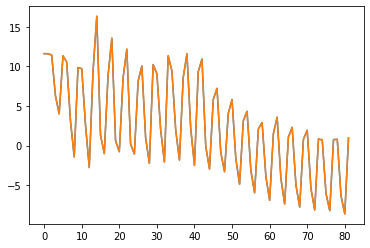

<ipython-input-39-f18830941536>:30: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pplot.pcolor(xx,yy,colorscale_fn(v[:,ids_sort]), **kwargs)


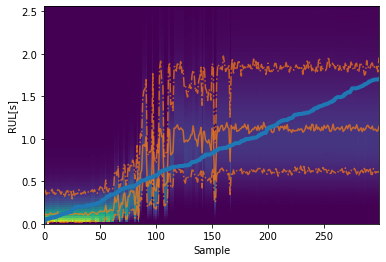

 40%|████      | 81/200 [01:39<02:28,  1.25s/it]

nnodes: 2, seq_range 20 epoch: 81


 41%|████      | 82/200 [01:40<02:22,  1.21s/it]

loss: -0.797, val_loss -0.797
lr_decay: setting lr to 0.00066
nnodes: 5, seq_range 150 epoch: 82


 42%|████▏     | 83/200 [01:41<02:20,  1.20s/it]

loss: -6.715, val_loss -6.715
lr_decay: setting lr to 0.00065
nnodes: 10, seq_range 150 epoch: 83


 42%|████▏     | 84/200 [01:43<02:37,  1.35s/it]

loss: -8.676, val_loss -8.676
lr_decay: setting lr to 0.00064
nnodes: 1, seq_range 2 epoch: 84


 42%|████▎     | 85/200 [01:44<02:16,  1.18s/it]

loss: 0.986, val_loss 0.986
lr_decay: setting lr to 0.00064
nnodes: 2, seq_range 20 epoch: 85


 43%|████▎     | 86/200 [01:45<02:08,  1.13s/it]

loss: -0.878, val_loss -0.878
lr_decay: setting lr to 0.00063
nnodes: 5, seq_range 150 epoch: 86


 44%|████▎     | 87/200 [01:46<02:08,  1.14s/it]

loss: -6.631, val_loss -6.631
lr_decay: setting lr to 0.00062
nnodes: 10, seq_range 150 epoch: 87


 44%|████▍     | 88/200 [01:48<02:19,  1.25s/it]

loss: -8.885, val_loss -8.885
lr_decay: setting lr to 0.00062
nnodes: 1, seq_range 2 epoch: 88


 44%|████▍     | 89/200 [01:48<02:01,  1.10s/it]

loss: 0.772, val_loss 0.772
lr_decay: setting lr to 0.00061
nnodes: 2, seq_range 20 epoch: 89


 45%|████▌     | 90/200 [01:49<01:55,  1.05s/it]

loss: -1.052, val_loss -1.052
lr_decay: setting lr to 0.00061
nnodes: 5, seq_range 150 epoch: 90
loss: -6.223, val_loss -6.223
lr_decay: setting lr to 0.00060


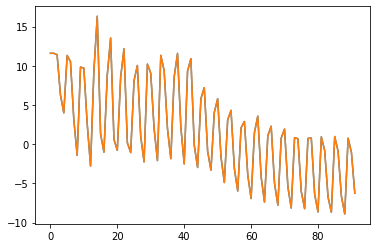

<ipython-input-39-f18830941536>:30: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pplot.pcolor(xx,yy,colorscale_fn(v[:,ids_sort]), **kwargs)


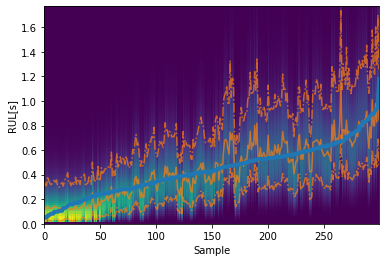

 46%|████▌     | 91/200 [01:51<02:14,  1.24s/it]

nnodes: 10, seq_range 150 epoch: 91


 46%|████▌     | 92/200 [01:53<02:35,  1.44s/it]

loss: -8.755, val_loss -8.755
lr_decay: setting lr to 0.00059
nnodes: 1, seq_range 2 epoch: 92


 46%|████▋     | 93/200 [01:54<02:14,  1.26s/it]

loss: 0.778, val_loss 0.778
lr_decay: setting lr to 0.00059
nnodes: 2, seq_range 20 epoch: 93


 47%|████▋     | 94/200 [01:55<02:03,  1.17s/it]

loss: -1.004, val_loss -1.004
lr_decay: setting lr to 0.00058
nnodes: 5, seq_range 150 epoch: 94


 48%|████▊     | 95/200 [01:56<02:02,  1.17s/it]

loss: -6.569, val_loss -6.569
lr_decay: setting lr to 0.00058
nnodes: 10, seq_range 150 epoch: 95


 48%|████▊     | 96/200 [01:57<02:11,  1.27s/it]

loss: -9.000, val_loss -9.000
lr_decay: setting lr to 0.00057
nnodes: 1, seq_range 2 epoch: 96


 48%|████▊     | 97/200 [01:58<01:54,  1.11s/it]

loss: -0.010, val_loss -0.010
lr_decay: setting lr to 0.00056
nnodes: 2, seq_range 20 epoch: 97


 49%|████▉     | 98/200 [01:59<01:50,  1.08s/it]

loss: -0.750, val_loss -0.750
lr_decay: setting lr to 0.00056
nnodes: 5, seq_range 150 epoch: 98


 50%|████▉     | 99/200 [02:00<01:51,  1.10s/it]

loss: -7.173, val_loss -7.173
lr_decay: setting lr to 0.00055
nnodes: 10, seq_range 150 epoch: 99


 50%|█████     | 100/200 [02:02<02:04,  1.25s/it]

loss: -9.320, val_loss -9.320
lr_decay: setting lr to 0.00055
nnodes: 1, seq_range 2 epoch: 100
loss: 0.016, val_loss 0.016
lr_decay: setting lr to 0.00054


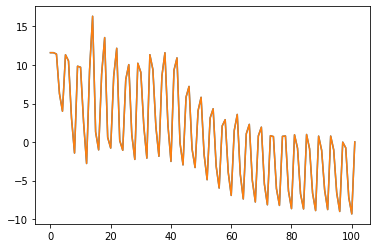

<ipython-input-39-f18830941536>:30: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pplot.pcolor(xx,yy,colorscale_fn(v[:,ids_sort]), **kwargs)


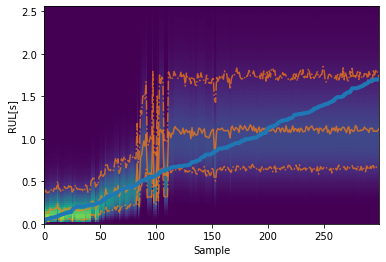

 50%|█████     | 101/200 [02:03<02:01,  1.22s/it]

nnodes: 2, seq_range 20 epoch: 101


 51%|█████     | 102/200 [02:04<01:56,  1.19s/it]

loss: -1.221, val_loss -1.221
lr_decay: setting lr to 0.00054
nnodes: 5, seq_range 150 epoch: 102


 52%|█████▏    | 103/200 [02:05<01:53,  1.17s/it]

loss: -7.511, val_loss -7.511
lr_decay: setting lr to 0.00053
nnodes: 10, seq_range 150 epoch: 103


 52%|█████▏    | 104/200 [02:07<02:01,  1.26s/it]

loss: -9.536, val_loss -9.536
lr_decay: setting lr to 0.00053
nnodes: 1, seq_range 2 epoch: 104


 52%|█████▎    | 105/200 [02:07<01:46,  1.12s/it]

loss: -0.070, val_loss -0.070
lr_decay: setting lr to 0.00052
nnodes: 2, seq_range 20 epoch: 105


 53%|█████▎    | 106/200 [02:08<01:40,  1.07s/it]

loss: -1.636, val_loss -1.636
lr_decay: setting lr to 0.00052
nnodes: 5, seq_range 150 epoch: 106


 54%|█████▎    | 107/200 [02:10<01:41,  1.09s/it]

loss: -7.661, val_loss -7.661
lr_decay: setting lr to 0.00051
nnodes: 10, seq_range 150 epoch: 107


 54%|█████▍    | 108/200 [02:11<01:51,  1.21s/it]

loss: -9.691, val_loss -9.691
lr_decay: setting lr to 0.00050
nnodes: 1, seq_range 2 epoch: 108


 55%|█████▍    | 109/200 [02:12<01:37,  1.07s/it]

loss: -0.233, val_loss -0.233
lr_decay: setting lr to 0.00050
nnodes: 2, seq_range 20 epoch: 109


 55%|█████▌    | 110/200 [02:13<01:33,  1.03s/it]

loss: -1.880, val_loss -1.880
lr_decay: setting lr to 0.00049
nnodes: 5, seq_range 150 epoch: 110
loss: -7.853, val_loss -7.853
lr_decay: setting lr to 0.00049


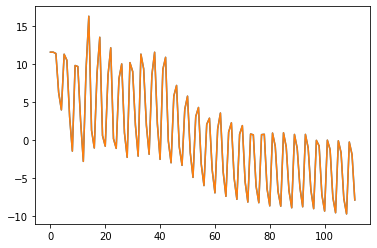

<ipython-input-39-f18830941536>:30: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pplot.pcolor(xx,yy,colorscale_fn(v[:,ids_sort]), **kwargs)


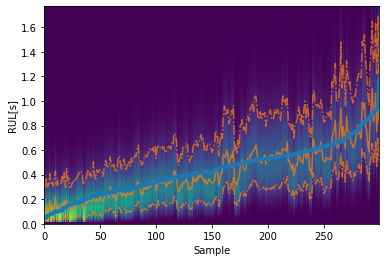

 56%|█████▌    | 111/200 [02:14<01:48,  1.22s/it]

nnodes: 10, seq_range 150 epoch: 111


 56%|█████▌    | 112/200 [02:16<02:03,  1.41s/it]

loss: -9.850, val_loss -9.850
lr_decay: setting lr to 0.00048
nnodes: 1, seq_range 2 epoch: 112


 56%|█████▋    | 113/200 [02:17<01:47,  1.23s/it]

loss: -0.496, val_loss -0.496
lr_decay: setting lr to 0.00048
nnodes: 2, seq_range 20 epoch: 113


 57%|█████▋    | 114/200 [02:18<01:40,  1.17s/it]

loss: -2.114, val_loss -2.114
lr_decay: setting lr to 0.00048
nnodes: 5, seq_range 150 epoch: 114


 57%|█████▊    | 115/200 [02:19<01:38,  1.16s/it]

loss: -8.028, val_loss -8.028
lr_decay: setting lr to 0.00047
nnodes: 10, seq_range 150 epoch: 115


 58%|█████▊    | 116/200 [02:21<01:45,  1.26s/it]

loss: -9.968, val_loss -9.968
lr_decay: setting lr to 0.00047
nnodes: 1, seq_range 2 epoch: 116


 58%|█████▊    | 117/200 [02:21<01:31,  1.11s/it]

loss: -0.814, val_loss -0.814
lr_decay: setting lr to 0.00046
nnodes: 2, seq_range 20 epoch: 117


 59%|█████▉    | 118/200 [02:22<01:28,  1.08s/it]

loss: -2.293, val_loss -2.293
lr_decay: setting lr to 0.00046
nnodes: 5, seq_range 150 epoch: 118


 60%|█████▉    | 119/200 [02:24<01:28,  1.10s/it]

loss: -8.160, val_loss -8.160
lr_decay: setting lr to 0.00045
nnodes: 10, seq_range 150 epoch: 119


 60%|██████    | 120/200 [02:25<01:40,  1.25s/it]

loss: -10.055, val_loss -10.055
lr_decay: setting lr to 0.00045
nnodes: 1, seq_range 2 epoch: 120
loss: -1.126, val_loss -1.126
lr_decay: setting lr to 0.00044


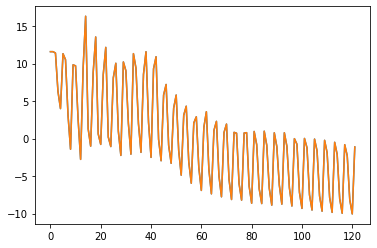

<ipython-input-39-f18830941536>:30: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pplot.pcolor(xx,yy,colorscale_fn(v[:,ids_sort]), **kwargs)


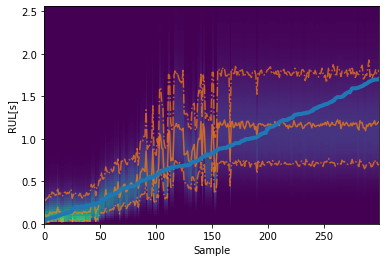

 60%|██████    | 121/200 [02:26<01:36,  1.23s/it]

nnodes: 2, seq_range 20 epoch: 121


 61%|██████    | 122/200 [02:27<01:32,  1.19s/it]

loss: -2.392, val_loss -2.392
lr_decay: setting lr to 0.00044
nnodes: 5, seq_range 150 epoch: 122


 62%|██████▏   | 123/200 [02:29<01:29,  1.16s/it]

loss: -8.206, val_loss -8.206
lr_decay: setting lr to 0.00043
nnodes: 10, seq_range 150 epoch: 123


 62%|██████▏   | 124/200 [02:30<01:39,  1.31s/it]

loss: -10.087, val_loss -10.087
lr_decay: setting lr to 0.00043
nnodes: 1, seq_range 2 epoch: 124


 62%|██████▎   | 125/200 [02:31<01:25,  1.15s/it]

loss: -1.302, val_loss -1.302
lr_decay: setting lr to 0.00043
nnodes: 2, seq_range 20 epoch: 125


 63%|██████▎   | 126/200 [02:32<01:23,  1.13s/it]

loss: -2.407, val_loss -2.407
lr_decay: setting lr to 0.00042
nnodes: 5, seq_range 150 epoch: 126


 64%|██████▎   | 127/200 [02:33<01:26,  1.18s/it]

loss: -8.179, val_loss -8.179
lr_decay: setting lr to 0.00042
nnodes: 10, seq_range 150 epoch: 127


 64%|██████▍   | 128/200 [02:35<01:32,  1.28s/it]

loss: -10.109, val_loss -10.109
lr_decay: setting lr to 0.00041
nnodes: 1, seq_range 2 epoch: 128


 64%|██████▍   | 129/200 [02:36<01:20,  1.14s/it]

loss: -1.429, val_loss -1.429
lr_decay: setting lr to 0.00041
nnodes: 2, seq_range 20 epoch: 129


 65%|██████▌   | 130/200 [02:37<01:16,  1.10s/it]

loss: -2.503, val_loss -2.503
lr_decay: setting lr to 0.00040
nnodes: 5, seq_range 150 epoch: 130
loss: -8.214, val_loss -8.214
lr_decay: setting lr to 0.00040


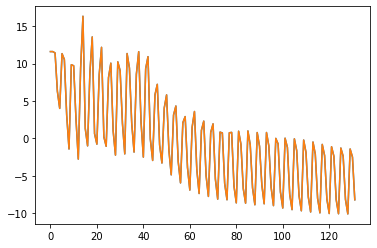

<ipython-input-39-f18830941536>:30: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pplot.pcolor(xx,yy,colorscale_fn(v[:,ids_sort]), **kwargs)


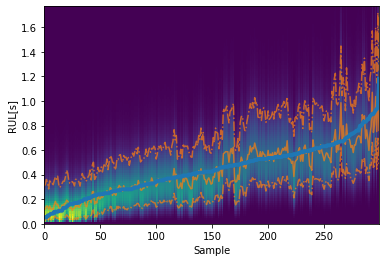

 66%|██████▌   | 131/200 [02:38<01:27,  1.27s/it]

nnodes: 10, seq_range 150 epoch: 131


 66%|██████▌   | 132/200 [02:40<01:36,  1.42s/it]

loss: -10.236, val_loss -10.236
lr_decay: setting lr to 0.00040
nnodes: 1, seq_range 2 epoch: 132


 66%|██████▋   | 133/200 [02:41<01:21,  1.22s/it]

loss: -1.525, val_loss -1.525
lr_decay: setting lr to 0.00039
nnodes: 2, seq_range 20 epoch: 133


 67%|██████▋   | 134/200 [02:42<01:16,  1.16s/it]

loss: -2.590, val_loss -2.590
lr_decay: setting lr to 0.00039
nnodes: 5, seq_range 150 epoch: 134


 68%|██████▊   | 135/200 [02:43<01:17,  1.20s/it]

loss: -8.377, val_loss -8.377
lr_decay: setting lr to 0.00038
nnodes: 10, seq_range 150 epoch: 135


 68%|██████▊   | 136/200 [02:45<01:25,  1.33s/it]

loss: -10.370, val_loss -10.370
lr_decay: setting lr to 0.00038
nnodes: 1, seq_range 2 epoch: 136


 68%|██████▊   | 137/200 [02:46<01:13,  1.17s/it]

loss: -1.547, val_loss -1.547
lr_decay: setting lr to 0.00038
nnodes: 2, seq_range 20 epoch: 137


 69%|██████▉   | 138/200 [02:47<01:09,  1.12s/it]

loss: -2.551, val_loss -2.551
lr_decay: setting lr to 0.00037
nnodes: 5, seq_range 150 epoch: 138


 70%|██████▉   | 139/200 [02:48<01:10,  1.15s/it]

loss: -8.476, val_loss -8.476
lr_decay: setting lr to 0.00037
nnodes: 10, seq_range 150 epoch: 139


 70%|███████   | 140/200 [02:49<01:17,  1.29s/it]

loss: -10.463, val_loss -10.463
lr_decay: setting lr to 0.00037
nnodes: 1, seq_range 2 epoch: 140
loss: -1.567, val_loss -1.567
lr_decay: setting lr to 0.00036


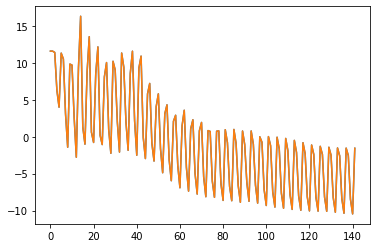

<ipython-input-39-f18830941536>:30: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pplot.pcolor(xx,yy,colorscale_fn(v[:,ids_sort]), **kwargs)


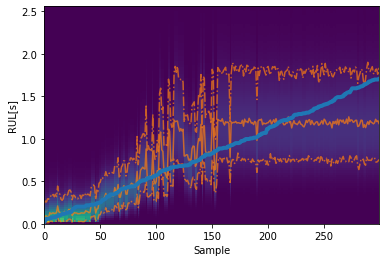

 70%|███████   | 141/200 [02:51<01:15,  1.28s/it]

nnodes: 2, seq_range 20 epoch: 141


 71%|███████   | 142/200 [02:52<01:11,  1.24s/it]

loss: -2.588, val_loss -2.588
lr_decay: setting lr to 0.00036
nnodes: 5, seq_range 150 epoch: 142


 72%|███████▏  | 143/200 [02:53<01:09,  1.23s/it]

loss: -8.541, val_loss -8.541
lr_decay: setting lr to 0.00036
nnodes: 10, seq_range 150 epoch: 143


 72%|███████▏  | 144/200 [02:55<01:15,  1.35s/it]

loss: -10.571, val_loss -10.571
lr_decay: setting lr to 0.00035
nnodes: 1, seq_range 2 epoch: 144


 72%|███████▎  | 145/200 [02:56<01:04,  1.18s/it]

loss: -1.677, val_loss -1.677
lr_decay: setting lr to 0.00035
nnodes: 2, seq_range 20 epoch: 145


 73%|███████▎  | 146/200 [02:57<01:01,  1.14s/it]

loss: -2.672, val_loss -2.672
lr_decay: setting lr to 0.00034
nnodes: 5, seq_range 150 epoch: 146


 74%|███████▎  | 147/200 [02:58<01:01,  1.17s/it]

loss: -8.636, val_loss -8.636
lr_decay: setting lr to 0.00034
nnodes: 10, seq_range 150 epoch: 147


 74%|███████▍  | 148/200 [02:59<01:07,  1.30s/it]

loss: -10.657, val_loss -10.657
lr_decay: setting lr to 0.00034
nnodes: 1, seq_range 2 epoch: 148


 74%|███████▍  | 149/200 [03:00<00:59,  1.16s/it]

loss: -1.659, val_loss -1.659
lr_decay: setting lr to 0.00033
nnodes: 2, seq_range 20 epoch: 149


 75%|███████▌  | 150/200 [03:01<00:56,  1.12s/it]

loss: -2.583, val_loss -2.583
lr_decay: setting lr to 0.00033
nnodes: 5, seq_range 150 epoch: 150
loss: -8.736, val_loss -8.736
lr_decay: setting lr to 0.00033


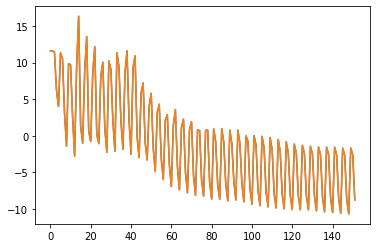

<ipython-input-39-f18830941536>:30: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pplot.pcolor(xx,yy,colorscale_fn(v[:,ids_sort]), **kwargs)


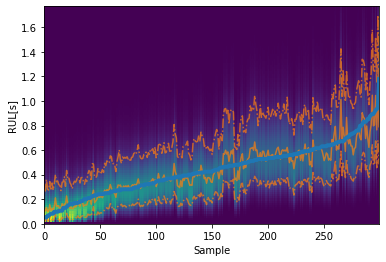

 76%|███████▌  | 151/200 [03:03<01:03,  1.29s/it]

nnodes: 10, seq_range 150 epoch: 151


 76%|███████▌  | 152/200 [03:05<01:10,  1.46s/it]

loss: -10.731, val_loss -10.731
lr_decay: setting lr to 0.00032
nnodes: 1, seq_range 2 epoch: 152


 76%|███████▋  | 153/200 [03:06<00:59,  1.26s/it]

loss: -1.600, val_loss -1.600
lr_decay: setting lr to 0.00032
nnodes: 2, seq_range 20 epoch: 153


 77%|███████▋  | 154/200 [03:07<00:54,  1.18s/it]

loss: -2.556, val_loss -2.556
lr_decay: setting lr to 0.00032
nnodes: 5, seq_range 150 epoch: 154


 78%|███████▊  | 155/200 [03:08<00:53,  1.18s/it]

loss: -8.825, val_loss -8.825
lr_decay: setting lr to 0.00031
nnodes: 10, seq_range 150 epoch: 155


 78%|███████▊  | 156/200 [03:09<00:58,  1.33s/it]

loss: -10.803, val_loss -10.803
lr_decay: setting lr to 0.00031
nnodes: 1, seq_range 2 epoch: 156


 78%|███████▊  | 157/200 [03:10<00:50,  1.17s/it]

loss: -1.628, val_loss -1.628
lr_decay: setting lr to 0.00031
nnodes: 2, seq_range 20 epoch: 157


 79%|███████▉  | 158/200 [03:11<00:47,  1.12s/it]

loss: -2.640, val_loss -2.640
lr_decay: setting lr to 0.00031
nnodes: 5, seq_range 150 epoch: 158


 80%|███████▉  | 159/200 [03:12<00:47,  1.15s/it]

loss: -8.920, val_loss -8.920
lr_decay: setting lr to 0.00030
nnodes: 10, seq_range 150 epoch: 159


 80%|████████  | 160/200 [03:14<00:51,  1.29s/it]

loss: -10.870, val_loss -10.870
lr_decay: setting lr to 0.00030
nnodes: 1, seq_range 2 epoch: 160
loss: -1.536, val_loss -1.536
lr_decay: setting lr to 0.00030


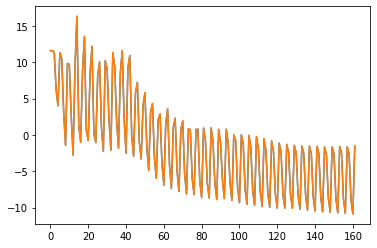

<ipython-input-39-f18830941536>:30: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pplot.pcolor(xx,yy,colorscale_fn(v[:,ids_sort]), **kwargs)


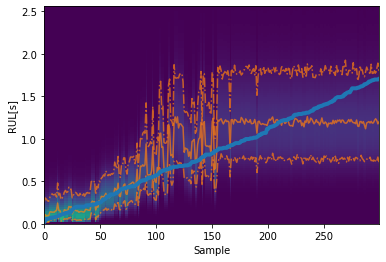

 80%|████████  | 161/200 [03:15<00:51,  1.32s/it]

nnodes: 2, seq_range 20 epoch: 161


 81%|████████  | 162/200 [03:16<00:46,  1.23s/it]

loss: -2.641, val_loss -2.641
lr_decay: setting lr to 0.00029
nnodes: 5, seq_range 150 epoch: 162


 82%|████████▏ | 163/200 [03:18<00:45,  1.22s/it]

loss: -8.994, val_loss -8.994
lr_decay: setting lr to 0.00029
nnodes: 10, seq_range 150 epoch: 163


 82%|████████▏ | 164/200 [03:19<00:48,  1.34s/it]

loss: -10.923, val_loss -10.923
lr_decay: setting lr to 0.00029
nnodes: 1, seq_range 2 epoch: 164


 82%|████████▎ | 165/200 [03:20<00:41,  1.18s/it]

loss: -1.467, val_loss -1.467
lr_decay: setting lr to 0.00028
nnodes: 2, seq_range 20 epoch: 165


 83%|████████▎ | 166/200 [03:21<00:38,  1.13s/it]

loss: -2.687, val_loss -2.687
lr_decay: setting lr to 0.00028
nnodes: 5, seq_range 150 epoch: 166


 84%|████████▎ | 167/200 [03:22<00:38,  1.15s/it]

loss: -9.028, val_loss -9.028
lr_decay: setting lr to 0.00028
nnodes: 10, seq_range 150 epoch: 167


 84%|████████▍ | 168/200 [03:24<00:41,  1.29s/it]

loss: -10.962, val_loss -10.962
lr_decay: setting lr to 0.00028
nnodes: 1, seq_range 2 epoch: 168


 84%|████████▍ | 169/200 [03:25<00:35,  1.14s/it]

loss: -1.510, val_loss -1.510
lr_decay: setting lr to 0.00027
nnodes: 2, seq_range 20 epoch: 169


 85%|████████▌ | 170/200 [03:26<00:32,  1.10s/it]

loss: -2.807, val_loss -2.807
lr_decay: setting lr to 0.00027
nnodes: 5, seq_range 150 epoch: 170
loss: -9.046, val_loss -9.046
lr_decay: setting lr to 0.00027


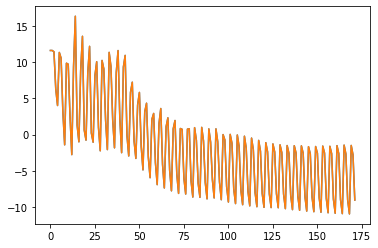

<ipython-input-39-f18830941536>:30: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pplot.pcolor(xx,yy,colorscale_fn(v[:,ids_sort]), **kwargs)


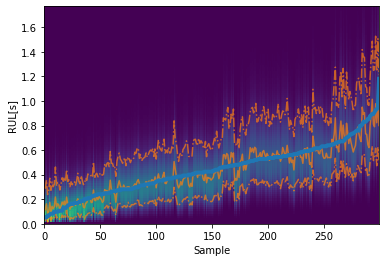

 86%|████████▌ | 171/200 [03:27<00:36,  1.27s/it]

nnodes: 10, seq_range 150 epoch: 171


 86%|████████▌ | 172/200 [03:29<00:40,  1.44s/it]

loss: -11.018, val_loss -11.018
lr_decay: setting lr to 0.00027
nnodes: 1, seq_range 2 epoch: 172


 86%|████████▋ | 173/200 [03:30<00:34,  1.26s/it]

loss: -1.563, val_loss -1.563
lr_decay: setting lr to 0.00026
nnodes: 2, seq_range 20 epoch: 173


 87%|████████▋ | 174/200 [03:31<00:31,  1.21s/it]

loss: -2.920, val_loss -2.920
lr_decay: setting lr to 0.00026
nnodes: 5, seq_range 150 epoch: 174


 88%|████████▊ | 175/200 [03:32<00:29,  1.20s/it]

loss: -9.062, val_loss -9.062
lr_decay: setting lr to 0.00026
nnodes: 10, seq_range 150 epoch: 175


 88%|████████▊ | 176/200 [03:34<00:31,  1.33s/it]

loss: -11.071, val_loss -11.071
lr_decay: setting lr to 0.00025
nnodes: 1, seq_range 2 epoch: 176


 88%|████████▊ | 177/200 [03:35<00:26,  1.17s/it]

loss: -1.682, val_loss -1.682
lr_decay: setting lr to 0.00025
nnodes: 2, seq_range 20 epoch: 177


 89%|████████▉ | 178/200 [03:36<00:24,  1.12s/it]

loss: -3.033, val_loss -3.033
lr_decay: setting lr to 0.00025
nnodes: 5, seq_range 150 epoch: 178


 90%|████████▉ | 179/200 [03:37<00:24,  1.15s/it]

loss: -9.090, val_loss -9.090
lr_decay: setting lr to 0.00025
nnodes: 10, seq_range 150 epoch: 179


 90%|█████████ | 180/200 [03:39<00:26,  1.31s/it]

loss: -11.115, val_loss -11.115
lr_decay: setting lr to 0.00024
nnodes: 1, seq_range 2 epoch: 180
loss: -1.812, val_loss -1.812
lr_decay: setting lr to 0.00024


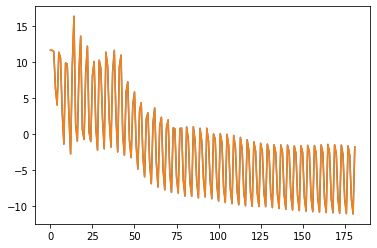

<ipython-input-39-f18830941536>:30: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pplot.pcolor(xx,yy,colorscale_fn(v[:,ids_sort]), **kwargs)


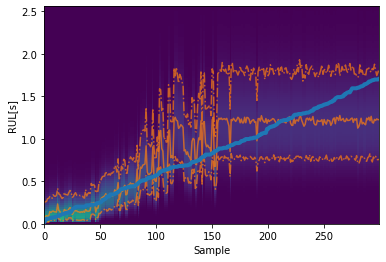

 90%|█████████ | 181/200 [03:40<00:24,  1.30s/it]

nnodes: 2, seq_range 20 epoch: 181


 91%|█████████ | 182/200 [03:41<00:22,  1.22s/it]

loss: -3.118, val_loss -3.118
lr_decay: setting lr to 0.00024
nnodes: 5, seq_range 150 epoch: 182


 92%|█████████▏| 183/200 [03:42<00:21,  1.27s/it]

loss: -9.134, val_loss -9.134
lr_decay: setting lr to 0.00024
nnodes: 10, seq_range 150 epoch: 183


 92%|█████████▏| 184/200 [03:44<00:22,  1.40s/it]

loss: -11.150, val_loss -11.150
lr_decay: setting lr to 0.00024
nnodes: 1, seq_range 2 epoch: 184


 92%|█████████▎| 185/200 [03:45<00:18,  1.22s/it]

loss: -1.940, val_loss -1.940
lr_decay: setting lr to 0.00023
nnodes: 2, seq_range 20 epoch: 185


 93%|█████████▎| 186/200 [03:46<00:16,  1.16s/it]

loss: -3.157, val_loss -3.157
lr_decay: setting lr to 0.00023
nnodes: 5, seq_range 150 epoch: 186


 94%|█████████▎| 187/200 [03:47<00:15,  1.17s/it]

loss: -9.183, val_loss -9.183
lr_decay: setting lr to 0.00023
nnodes: 10, seq_range 150 epoch: 187


 94%|█████████▍| 188/200 [03:49<00:15,  1.31s/it]

loss: -11.176, val_loss -11.176
lr_decay: setting lr to 0.00023
nnodes: 1, seq_range 2 epoch: 188


 94%|█████████▍| 189/200 [03:50<00:12,  1.16s/it]

loss: -2.041, val_loss -2.041
lr_decay: setting lr to 0.00022
nnodes: 2, seq_range 20 epoch: 189


 95%|█████████▌| 190/200 [03:51<00:11,  1.11s/it]

loss: -3.133, val_loss -3.133
lr_decay: setting lr to 0.00022
nnodes: 5, seq_range 150 epoch: 190
loss: -9.201, val_loss -9.201
lr_decay: setting lr to 0.00022


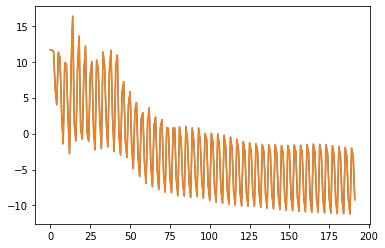

<ipython-input-39-f18830941536>:30: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pplot.pcolor(xx,yy,colorscale_fn(v[:,ids_sort]), **kwargs)


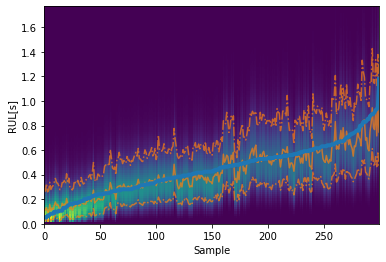

 96%|█████████▌| 191/200 [03:52<00:11,  1.29s/it]

nnodes: 10, seq_range 150 epoch: 191


 96%|█████████▌| 192/200 [03:54<00:11,  1.47s/it]

loss: -11.193, val_loss -11.193
lr_decay: setting lr to 0.00022
nnodes: 1, seq_range 2 epoch: 192


 96%|█████████▋| 193/200 [03:55<00:08,  1.27s/it]

loss: -2.104, val_loss -2.104
lr_decay: setting lr to 0.00021
nnodes: 2, seq_range 20 epoch: 193


 97%|█████████▋| 194/200 [03:56<00:07,  1.19s/it]

loss: -3.085, val_loss -3.085
lr_decay: setting lr to 0.00021
nnodes: 5, seq_range 150 epoch: 194


 98%|█████████▊| 195/200 [03:57<00:05,  1.20s/it]

loss: -9.198, val_loss -9.198
lr_decay: setting lr to 0.00021
nnodes: 10, seq_range 150 epoch: 195


 98%|█████████▊| 196/200 [03:59<00:05,  1.33s/it]

loss: -11.210, val_loss -11.210
lr_decay: setting lr to 0.00021
nnodes: 1, seq_range 2 epoch: 196


 98%|█████████▊| 197/200 [04:00<00:03,  1.16s/it]

loss: -2.145, val_loss -2.145
lr_decay: setting lr to 0.00021
nnodes: 2, seq_range 20 epoch: 197


 99%|█████████▉| 198/200 [04:01<00:02,  1.12s/it]

loss: -2.998, val_loss -2.998
lr_decay: setting lr to 0.00020
nnodes: 5, seq_range 150 epoch: 198


100%|█████████▉| 199/200 [04:02<00:01,  1.14s/it]

loss: -9.179, val_loss -9.179
lr_decay: setting lr to 0.00020
nnodes: 10, seq_range 150 epoch: 199


100%|██████████| 200/200 [04:03<00:00,  1.22s/it]

loss: -11.224, val_loss -11.224
lr_decay: setting lr to 0.00020


In [42]:
n_epochs = 200
nnodes_schedule = [1,2,5,10]
nseq_range_schedule = [2,20,150,150]
min_spacing_schedule = [1,5,5,5]
iterations_schedule = [3]
nbatch = 300
val_pct = 0.2 # percentage of sequence samples from the **seen ** experiments used as a validation set.
fixed_spacing_indices = False

eval_mode = "batched"
from tqdm import tqdm
for i in tqdm(range(n_epochs)):
    np.random.seed(42); 
    epoch = i
    
    # This makes sure that I always get different training and validation sets (there can still be some overlap but training should work ok)
    nnodes      = nnodes_schedule[i%len(nnodes_schedule)]
    nseq_range  = nseq_range_schedule[i%len(nseq_range_schedule)]
    min_spacing = min_spacing_schedule[i%len(min_spacing_schedule)]
    iterations = iterations_schedule[i%len(iterations_schedule)]
    
    if (nnodes * min_spacing) > nseq_range:
        min_spacing = 10
        nseq_range = nnodes * min_spacing+10
        
    print("nnodes: %i, seq_range %i epoch: %i"%(nnodes, nseq_range, i))
    curr_data = get_multi_batch_fictitious(nbatch, source_ds=True,nnodes=nnodes,
                                min_spacing = min_spacing,
                                nseq_range = nseq_range,
                                fixed_spacing_indices=fixed_spacing_indices);
    
    loss_epoch = 0;
    val_loss_epoch = 0;
    
    for single_minibatch in curr_data:
        with tf.GradientTape() as tape:
            graph_curr, y_curr = single_minibatch;
            prob_out = gn_tot.eval_graphnets(graph_curr.copy(), iterations, eval_mode=eval_mode)
            loss_vals = -prob_out.log_prob(y_curr[np.newaxis].T)
            
            all_weights =gn_tot.weights() 
            
            
            train_loss = loss_vals[0:int(nbatch*(1-val_pct))];
            
            grads = tape.gradient(train_loss, all_weights)
            all_weights_filt = [all_weights[k] for k in range(len(grads)) if grads[k] is not None]
            grads_filt = [grads[k] for k in range(len(grads)) if grads[k] is not None]
            opt.apply_gradients(zip(grads_filt, all_weights_filt))
            loss_epoch += train_loss/len(y_curr)
          
        val_loss_epoch += tf.reduce_mean(loss_vals[int(-nbatch*(val_pct)):])
        
    loss_log.append_loss(np.sum(loss_epoch.numpy()))
    loss_log.append_val_loss(np.sum(val_loss_epoch.numpy()))
    loss_log.print()
    lr_scheduler.on_epoch_end(epoch)
    if early_stop.on_epoch_end(epoch):
        break
        
    if epoch%10 == 0:
        pplot.plot(loss_log.loss_history['loss'])
        pplot.plot(loss_log.loss_history['val_loss'])
        pplot.show()
        plot_experiment_fit(curr_data[0], iterations = iterations_schedule[-1])
        pplot.show()

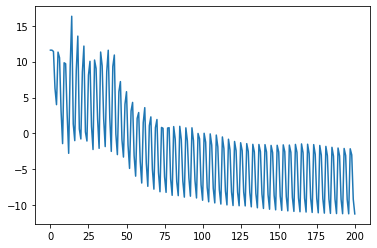

In [43]:
pplot.plot(loss_log.loss_history['val_loss'])
pplot.show()

In [44]:
help(get_graph_data_multiple_experiments)


    

Help on function get_graph_data_multiple_experiments in module utils:

get_graph_data_multiple_experiments(experiments, X_=None, eid_oh_=None, yrem_norm_=None, nsamples_per_experiment=None, nnodes=None, min_spacing=None, nseq_range=None, fixed_spacing_indices=False, full_past_params=None)
    If the sequence length of a dataset is larger than the available points the 
    sequence is truncated to the largest number of available points.



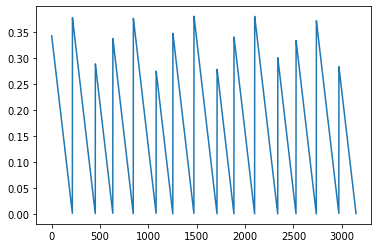

In [45]:

pplot.plot(fic.yrem_norm)

In [50]:
csfont = {'fontname':'Times New Roman','fontsize' : 24}

def plot_experiments(experiments_to_plot, eval_mode = "safe",
                     nseq_len = None, xaxis_sample = False, max_time = 2.5):
    #training = inds_exp_source
    nsampled = 500

    pplot.figure(figsize = (15,int(10/3*len(experiments_to_plot))), dpi = 300)
    nnodes_list = [1,5,10]#,3,5]
    if nseq_len is None:
        nseq_len = [100,100,100]
    
    minspacing= [5,5,5]
    gnsteps  = [ 3,3,3]
    
    normalization_factor_time = 1;#fic.normalization_factor_time #femto_dataset.normalization_factor_time
    plt_data = [];
    kk = 0;
    return_values = [] 
    for exp_index , ee in enumerate(experiments_to_plot):
        for nnodes, gnsteps_,nseq_,minspacing_ in zip(nnodes_list, gnsteps, nseq_len, minspacing):
                        
            graphs, y_times = get_graph_data(ee, X_ = fic_test.X, eid_oh_ = fic_test.eid_oh,
                                             yrem_norm_ = fic_test.yrem_norm, n_sampled_graphs = nsampled,
                                             nnodes=nnodes, fixed_spacing_indices=False, min_spacing=minspacing_,
                                             nseq_range=nseq_)
            probs = gn_tot.eval_graphnets(graphs,gnsteps_,eval_mode = eval_mode)
            
            if max_time is None:
                max_time = np.max(y)*1.5

            ids_sorted = np.argsort(y_times.flatten())
            time_grid= np.linspace(0,max_time,102)
            tohours = lambda x : x 
            
            #time_grid = np.linspace(np.min(y_times),3.5, 150);
                #ind_exp = 0;

            e_y = probs.mean()
            p_y = probs.prob(time_grid).numpy().T
            
            y_times_sorted = y_times[ids_sorted].flatten();
            return_values.append((y_times_sorted))
            
            y_times_sorted_unnorm = y_times_sorted * normalization_factor_time;
            pplot.subplot( len(experiments_to_plot),len(nnodes_list), kk+1)
            q90 = np.quantile(probs.sample(1000).numpy(),[0.05,0.95],0)[:,:,0].T[ids_sorted]
            
            
            
            if xaxis_sample:
                assert(0)
                
            else:
                pplot.pcolor(tohours(y_times_sorted_unnorm.flatten()), tohours(time_grid*normalization_factor_time), p_y[:,ids_sorted].squeeze()**0.5, cmap = "gray")
                pplot.plot(tohours(y_times_sorted_unnorm.flatten()), tohours(y_times_sorted  *normalization_factor_time), linewidth = 7)
                
            #pplot.plot(tohours(y_times_sorted_unnorm),tohours(q90*femto_dataset.normalization_factor_time),'C1-.', alpha = 0.4)
            #pplot.plot(e_y.numpy()[ids_sorted]*normalization_factor_time,'C1',label = "$E[t_f]$",alpha = 0.5)<3
            
            #pplot.plot(tohours(y_times_sorted_unnorm).flatten(),tohours(q90*fic.normalization_factor_time).squeeze(),'C1-.', alpha = 0.4)
            pplot.plot(tohours(y_times_sorted_unnorm),tohours(q90*normalization_factor_time),'C1-.', alpha = 0.4)
            
            pplot.ylim(0,tohours(max_time))
            if nnodes == 1:
                #pplot.ylabel("Experiment %i/%s\nPredicted RUL[h]"%(ee,femto_dataset.file_suffix[ee]), fontsize = 20)
                pplot.ylabel("Experiment %s\nPredicted RUL[h]"%(ee), **csfont)
                
            #pplot.xlabel("Actual time to failure [s]")
            
            #pplot.ylabel("Predicted time to failure [s]")
            
            #pplot.xlabel("Predicted RUL[h]",fontsize = 20)

            nll = -np.mean(probs.log_prob(y_times[np.newaxis].T))
            
            parameters = {'nnodes' : nnodes, 'gnsteps' : gnsteps_ ,  'minspacing_' : minspacing}
            density_plot = {'density_plot' : (y_times_sorted_unnorm, time_grid * normalization_factor_time, p_y[:, ids_sorted]**0.5), 
                            'actual_ttf_line' : (y_times_sorted_unnorm, y_times_sorted  *normalization_factor_time), 
                            'eval_parameters' : parameters}
            quantiles = {'quantiles' : (y_times_sorted_unnorm,q90*fic.normalization_factor_time)}
            loss = {'experiment' : ee, 'nll' : nll}
            plt_data.append({'loss' : loss,'quantiles' : quantiles , 'density_plot' : density_plot, 'parameters'  : parameters})
            
            
            if exp_index == 0:
                title = "Obs.:%i\nNLL:%2.3f"%(nnodes,nll)
            else:
                title = "NLL:%2.3f"%(nll)
            
            if exp_index == (len(experiments_to_plot)-1):
                pplot.xlabel("Actual RUL[h]", **csfont)
            
            pplot.title(title, **csfont)
            kk+=1
    pplot.subplots_adjust(hspace = 0.30, wspace = 0.30)
    return return_values
            
    
    #return plt_data

<ipython-input-50-4ec2a6b3e09d>:55: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pplot.pcolor(tohours(y_times_sorted_unnorm.flatten()), tohours(time_grid*normalization_factor_time), p_y[:,ids_sorted].squeeze()**0.5, cmap = "gray")
<ipython-input-50-4ec2a6b3e09d>:55: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pplot.pcolor(tohours(y_times_sorted_unnorm.flatten()), tohours(time_grid*normalization_factor_time), p_y[:,ids_sorted].squeeze()**0.5, cmap = "gray"

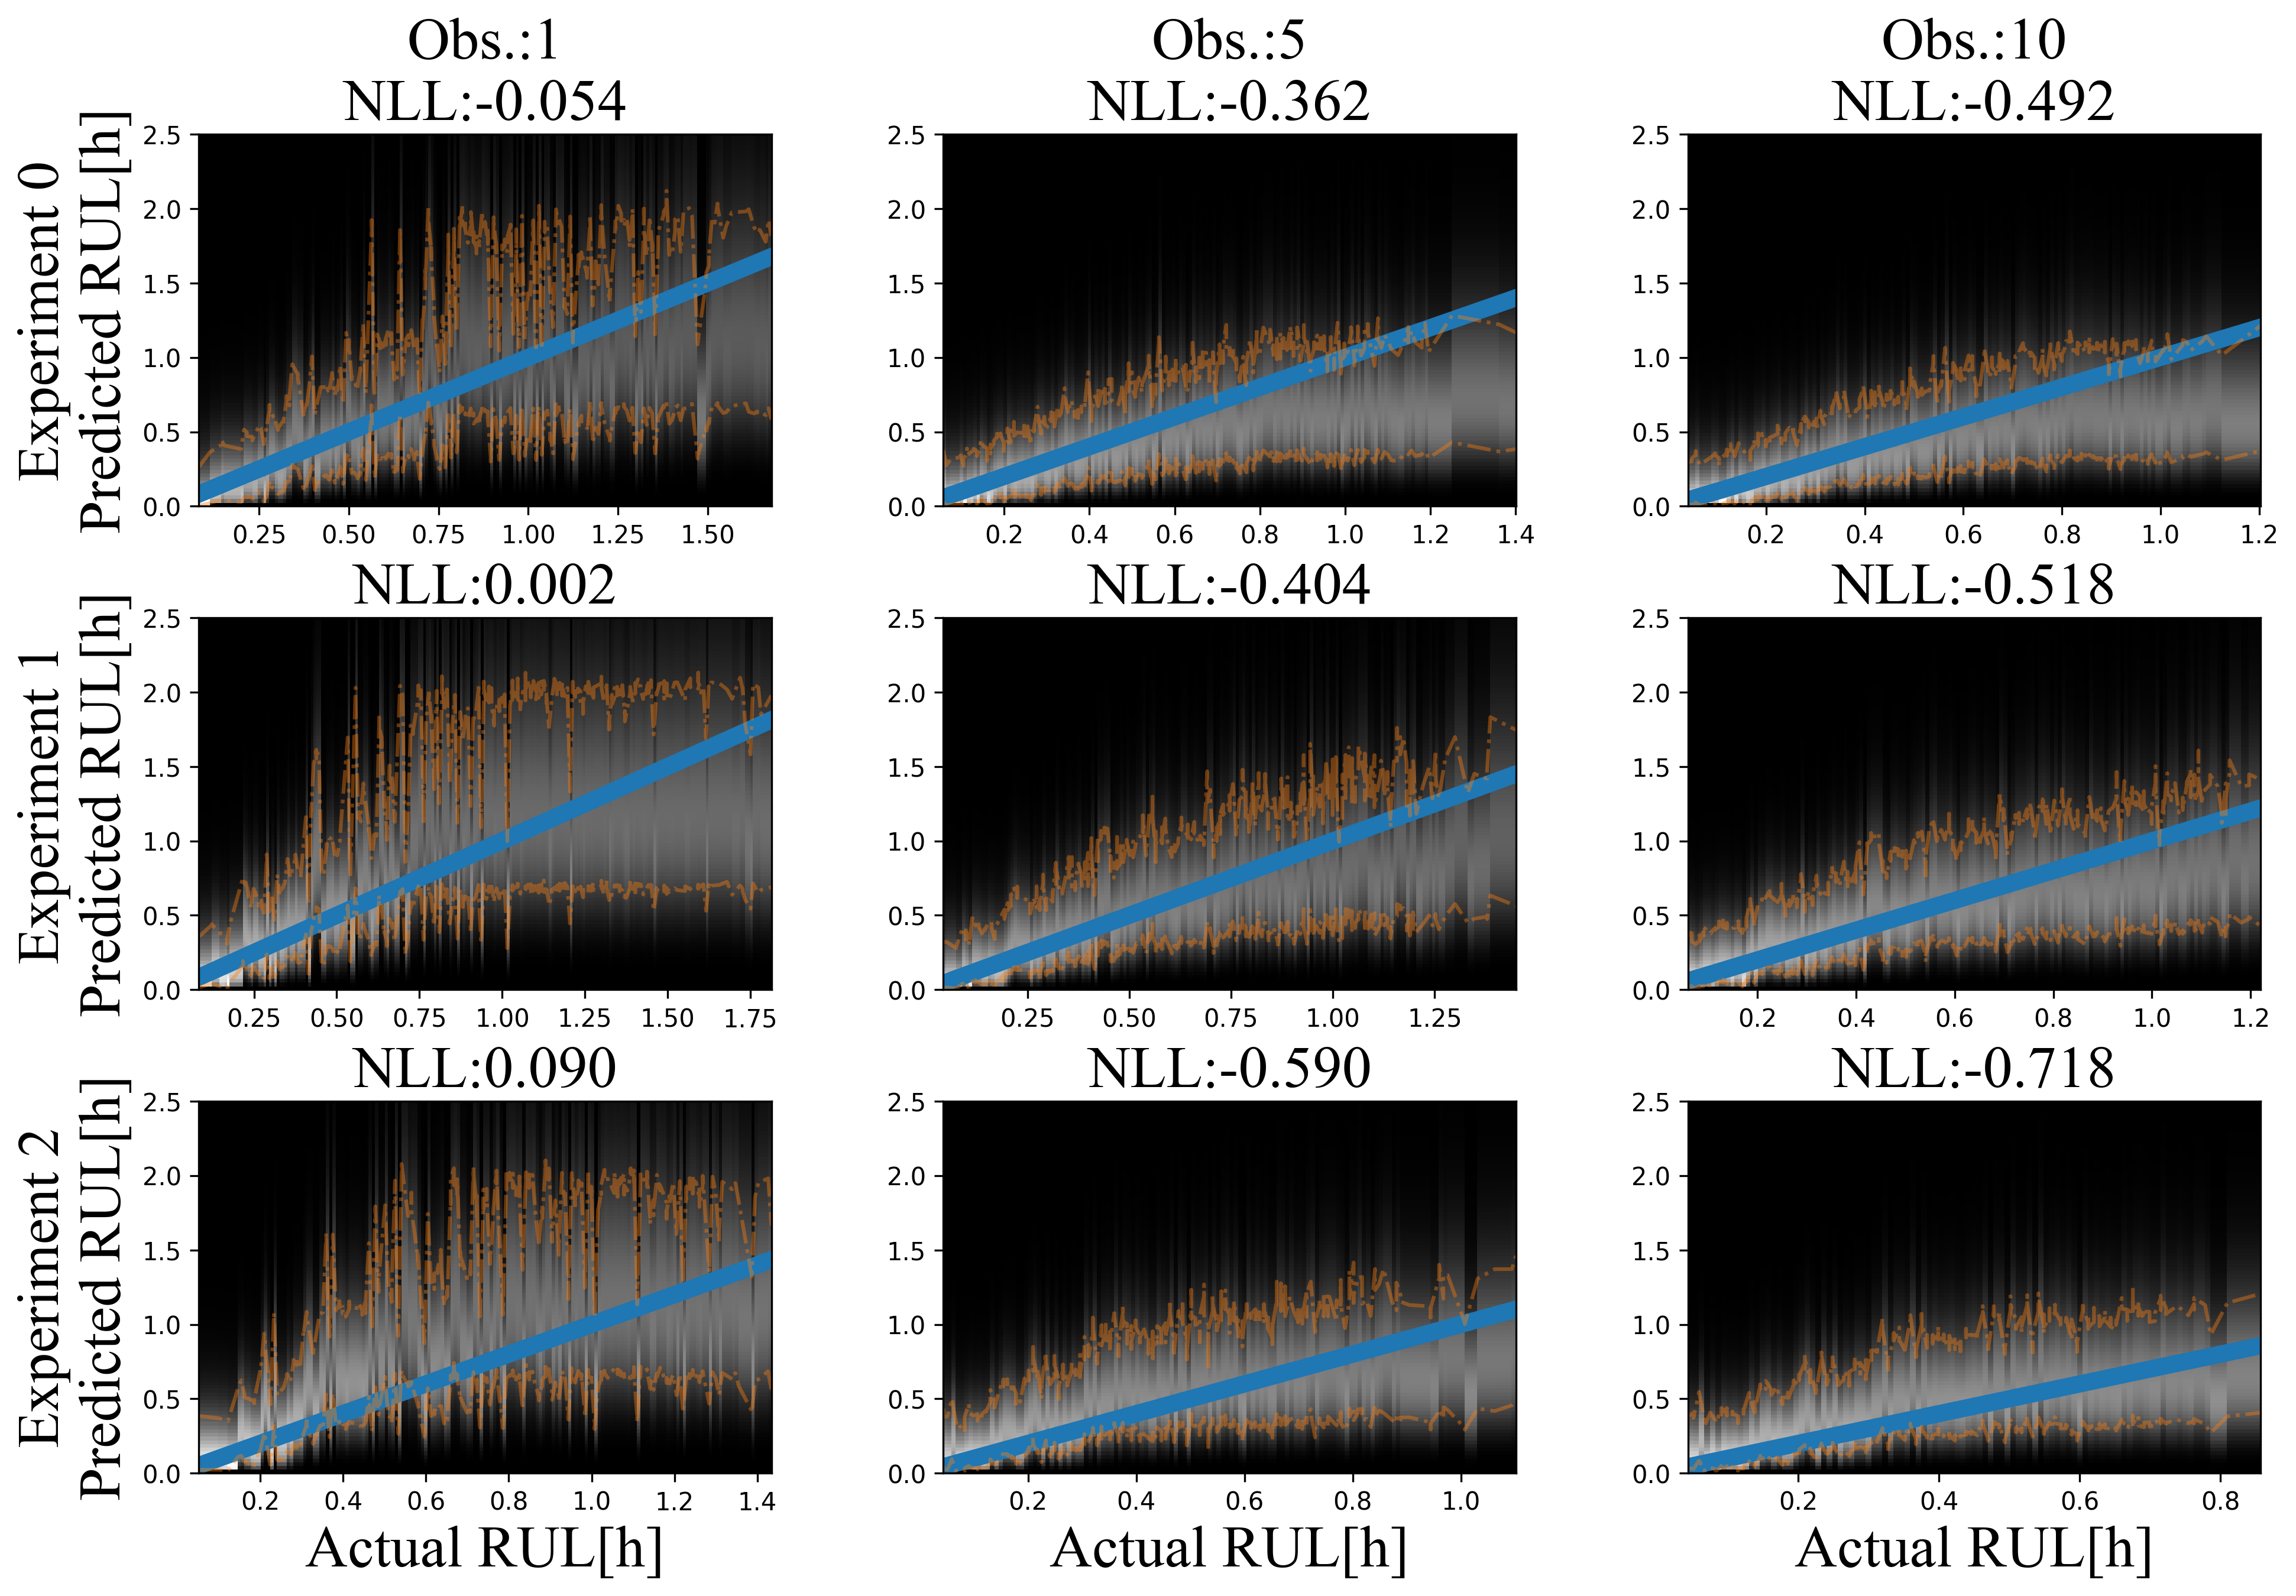

In [51]:
vv = plot_experiments([0,1,2])
pplot.savefig("fictitious_GNN-tCNN.png")
!cp fictitious_GNN-tCNN.png /home/charilaos/Workspace/ETH_WindmilRepositories/GraphNetCNN-paper/figures/

In [52]:
!cp fictitious_GNN-tCNN.png /home/charilaos/Workspace/ETH_WindmilRepositories/GraphNetCNN-paper/figures/
!cp fictitious_GNN-tCNN.png /home/charilaos/Workspace/ETH_WindmilRepositories/GraphNetCNN-paper/to_mssp/figures/


<Figure size 1440x720 with 0 Axes>

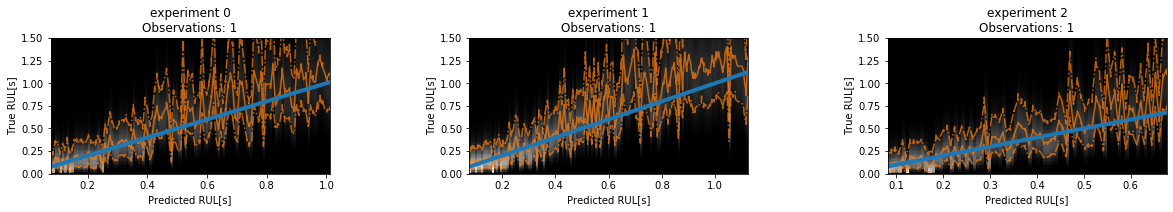

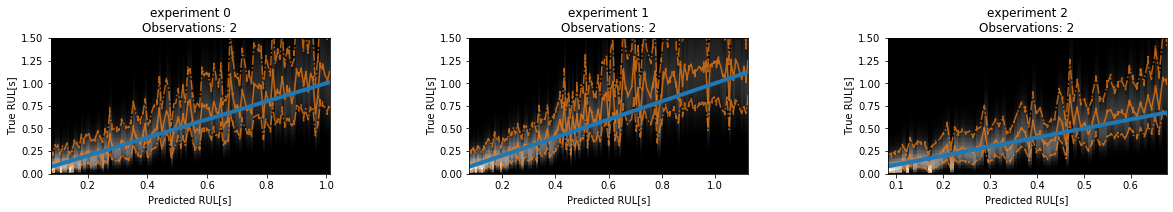

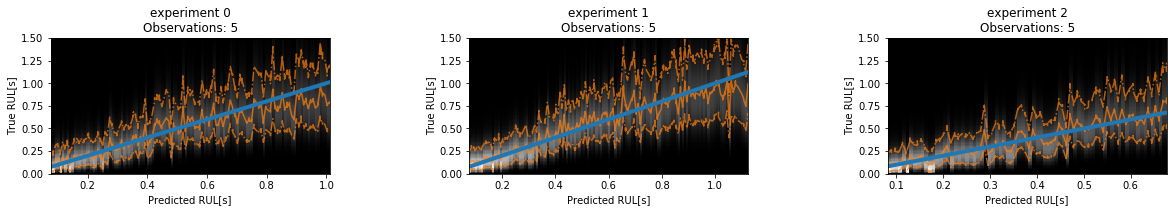

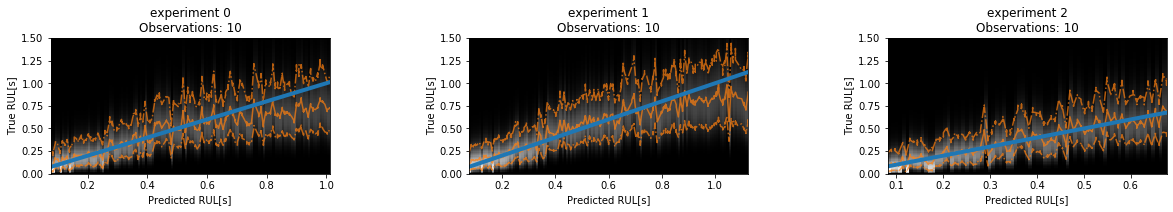

In [210]:
from IPython.display import clear_output
min_spacing = 10;
nseq_range = 100
nnodes_max = 10;
test_data = get_graph_data_multiple_experiments(fic.inds_exp_target,fic.X,
                                                eid_oh_ = fic.eid_oh,
                                                yrem_norm_ = fic.yrem_norm ,
                                                nsamples_per_experiment = 500, 
                                                nnodes = nnodes_max, 
                                                min_spacing = min_spacing, nseq_range=nseq_range)
pplot.figure(figsize = (20,10));
for nnodes in [1,2,5,10]:
#nnodes = 2

    pplot.figure(figsize = (20,10));

    #test_data = get_graph_data_multiple_experiments(fic.inds_exp_target,fic.X, eid_oh_ = fic.eid_oh, yrem_norm_ = fic.yrem_norm ,
    #                                       nsamples_per_experiment = 500, nnodes = nnodes, min_spacing = min_spacing, nseq_range=nseq_range)
    if nnodes > 1:
        t = [(t_[0].get_subgraph_from_nodes([*t_[0].nodes[-nnodes:]]), t_[1]) for t_ in test_data]
    else:
        t = [(t_[0].get_subgraph_from_nodes([t_[0].nodes[-nnodes]]),t_[1]) for t_ in test_data]
        
    for idx_experiment,data in enumerate(t):
        pplot.subplot(3,3,idx_experiment +1, title = "experiment {}\nObservations: {}".format(idx_experiment, nnodes))
        plot_experiment_fit_v2(data, iterations=3, colorscale_fn = lambda x : x,max_time = 1.5, cmap = "gray")
    pplot.subplots_adjust(wspace=0.5, hspace = 0.5)

In [69]:
# #def trim_nodes
# g = graph_dat[0].copy()
# g.nodes[-1]


In [70]:
# import numpy as np
# np.random.choice(10,10, replace = False)


In [214]:
def get_subgraph_from_nodes(graph, nodes):
    """
    Node should belong to graph. Creates a new graph with coppied edge and 
    node properties, defined from a sub-graph of the original graph.
    parameters:
      graph: the graph we want a sub-graph from 
      nodes: the nodes of the graph we want the subgraph of.
    """
    edges = graph.edges
    sg_nodes_copy = [n.copy() for n in nodes]
    original_copy_nodes_correspondence = {n:nc for n, nc in zip(nodes, sg_nodes_copy)}
    sg_edges_copy = [];
    if len(edges) > 0:
        for e in graph.edges:
            if (e.node_from in nodes) and (e.node_to in nodes):
                sg_edges_copy.append(e.copy(original_copy_nodes_correspondence))
    return Graph(sg_nodes_copy, sg_edges_copy)

#gnew = get_subgraph_from_nodes(graph_dat[0],graph_dat[0].nodes[-1:])
        
#edges_going_to_nodes()
#g.nodes[-1]

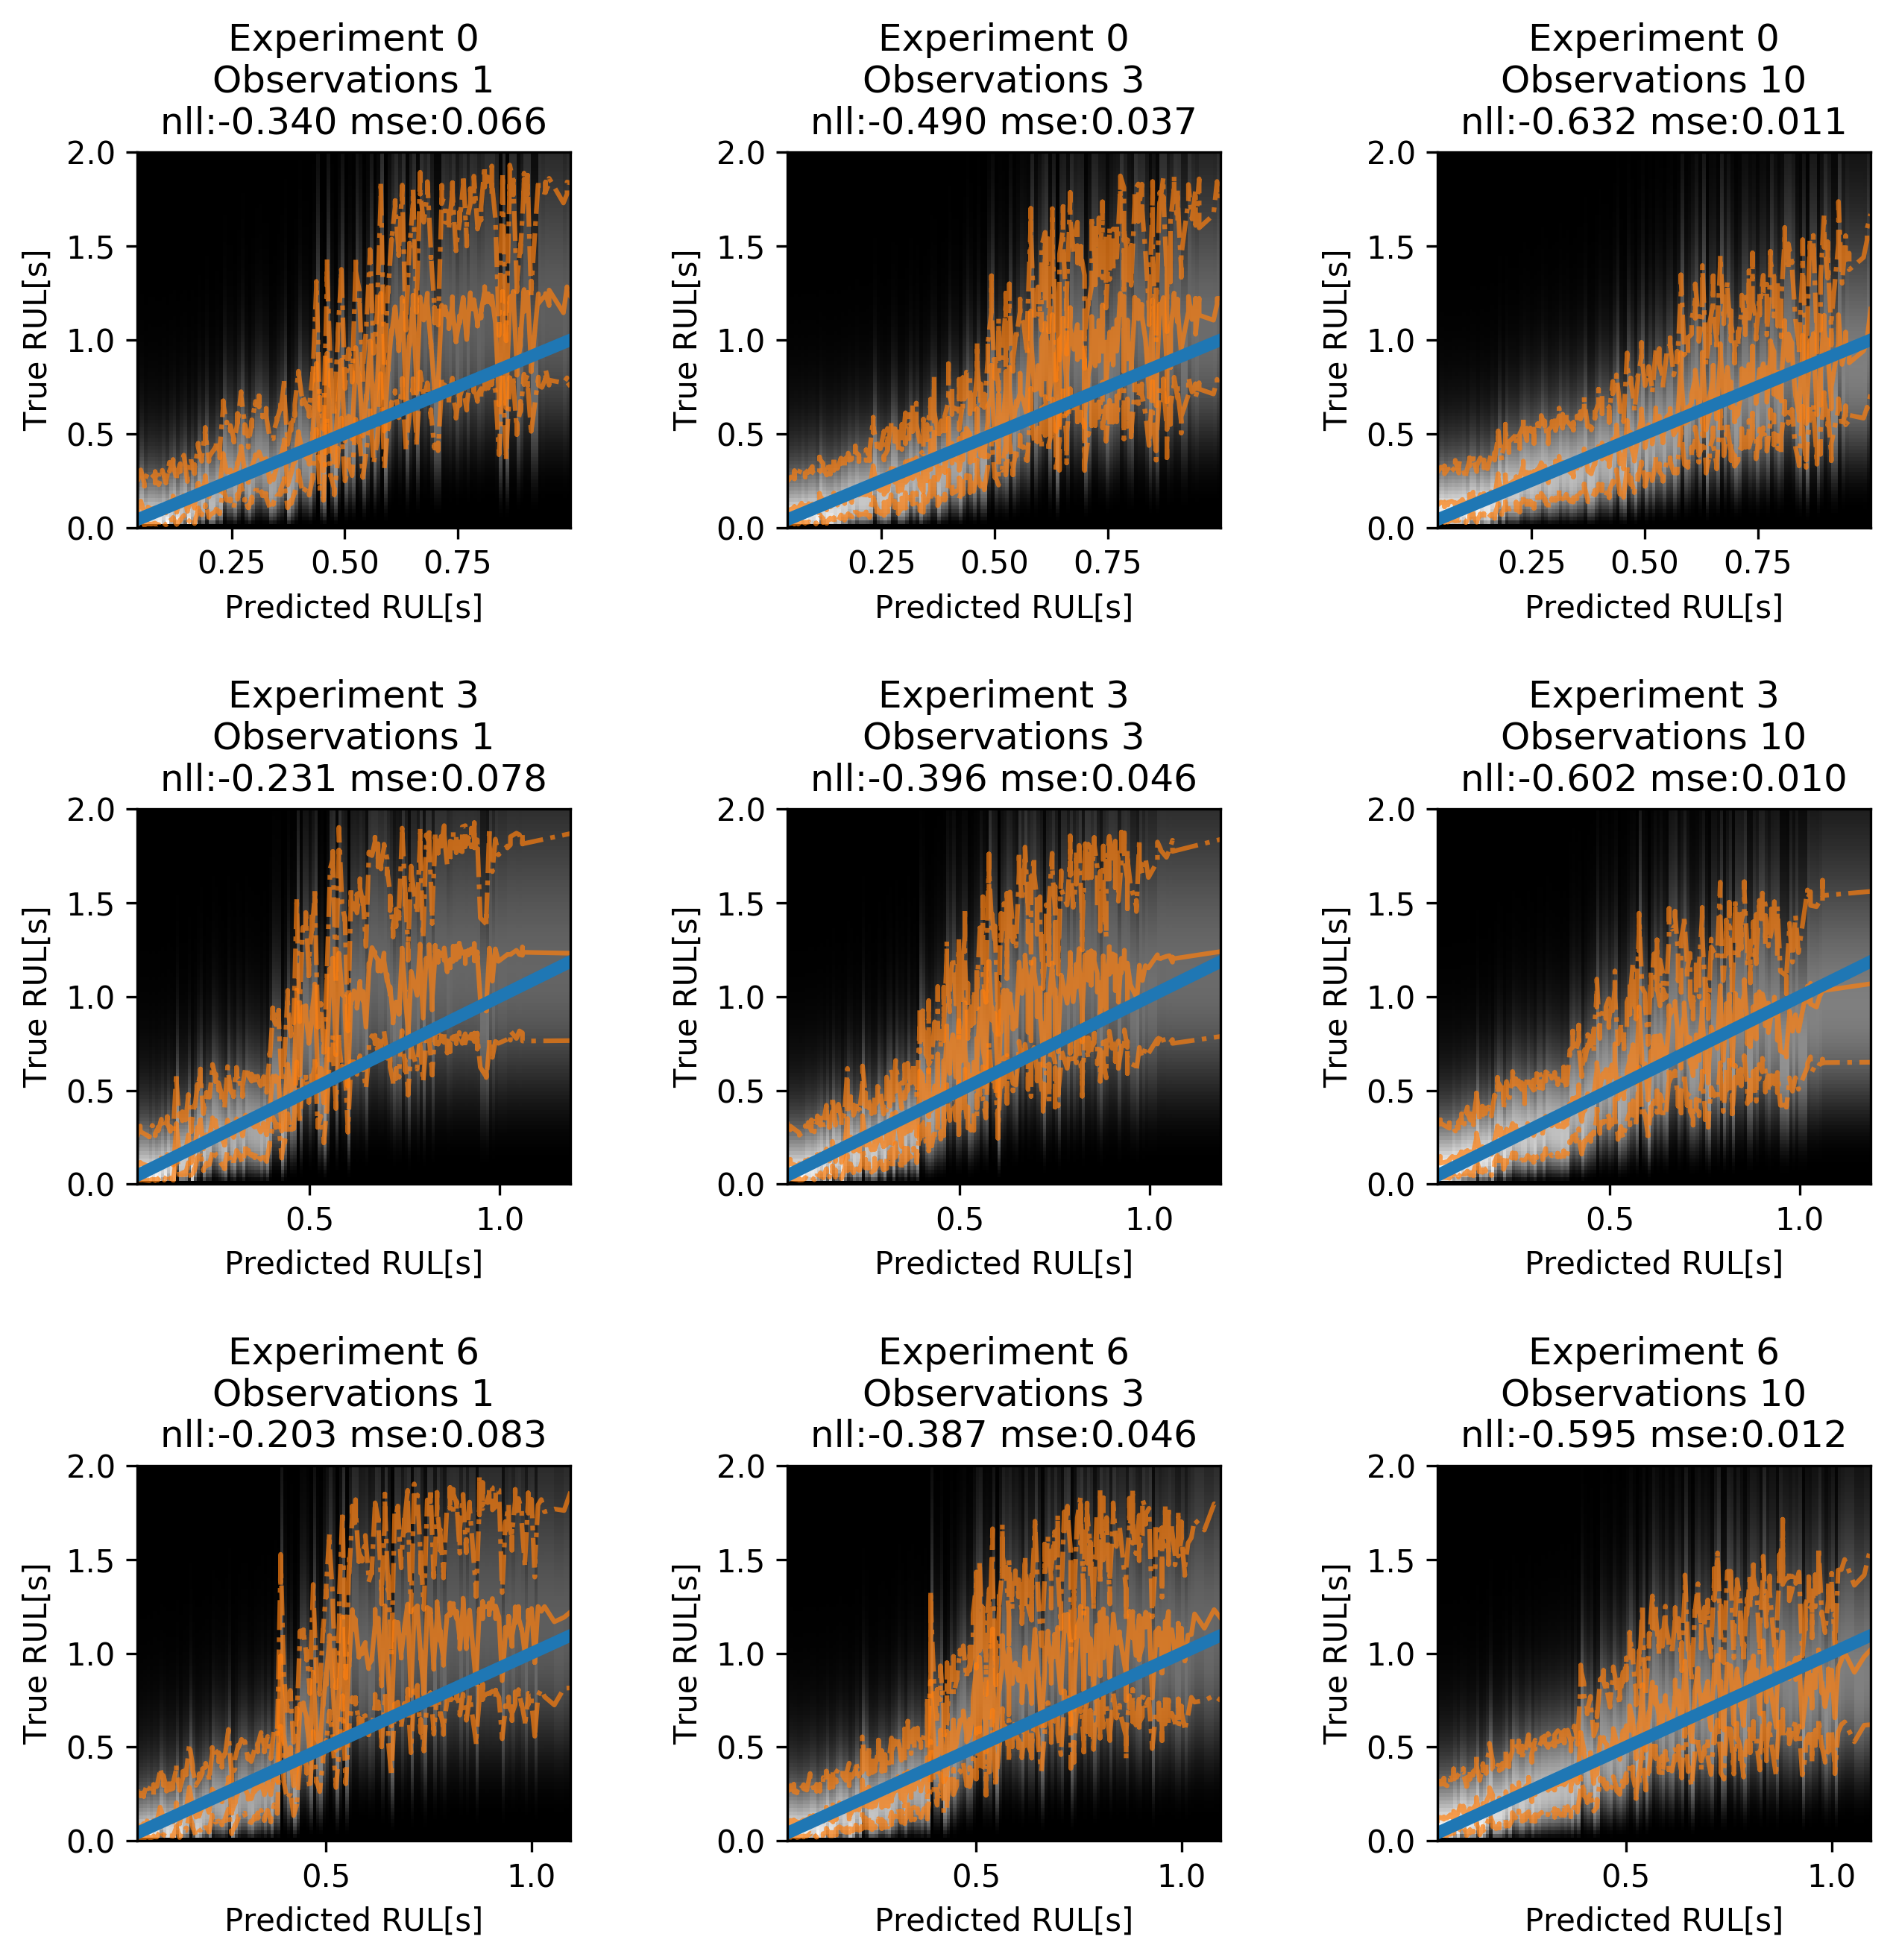

In [216]:
nsampled_graphs = 500;
nnodes_vals = [1, 3,10];
idx_plot = 1
nseq_range = 100
min_spacing = 5
niters = 5



pplot.figure(figsize = (10,10), dpi = 300)
for t in fic.inds_exp_source[0:3]:
    graph_dat10 = get_graph_data( t , X_ = fic.X, eid_oh_ = fic.eid_oh, yrem_norm_=fic.yrem_norm, 
               n_sampled_graphs = nsampled_graphs,nnodes = 10,
               min_spacing = min_spacing, nseq_range = nseq_range)

    for nnodes in nnodes_vals:
        pplot.subplot(len(fic.inds_exp_target), len(nnodes_vals),idx_plot)
        idx_plot += 1
#         graph_dat = get_graph_data( t , X_ = fic.X, eid_oh_ = fic.eid_oh, yrem_norm_=fic.yrem_norm, 
#                        n_sampled_graphs = nsampled_graphs,nnodes = nnodes,
#                        min_spacing = min_spacing, nseq_range = nseq_range)
        graph_input = get_subgraph_from_nodes(graph_dat10[0], graph_dat10[0].nodes[-nnodes:])
        yval = graph_dat10[1]
        ginp = (graph_input, yval)
        res = plot_experiment_fit_v2(ginp, iterations=niters, colorscale_fn = lambda x : x**0.5,max_time = 2., cmap = "gray")
        nll = res[-1]
        mse = np.mean((res[3] - graph_dat10[1])**2)
        title_str = "Experiment {t}\nObservations {nnodes}\nnll:{nll:2.3f} mse:{mse:2.3f}".format(t=t, nnodes=nnodes, nll = nll, mse = mse)
        pplot.title(title_str)

pplot.subplots_adjust(wspace=0.5, hspace = 0.75)

In [65]:
np.mean(np.abs(res[3]- graph_dat10[1])/(graph_dat10[1]))

0.20260455679742118

In [87]:
a = 43
"{a:2.3f}".format(a=3.34122322)

'3.341'

Help on function plot_experiment_fit in module __main__:

plot_experiment_fit(graph_and_result_tuple, iterations=5, max_time=None, colorscale_fn=<function <lambda> at 0x7fa7995dd840>, **kwargs)



In [50]:
help(get_graph_data)

Help on function get_graph_data in module utils:

get_graph_data(experiment, X_=None, eid_oh_=None, yrem_norm_=None, n_sampled_graphs=100, nnodes=3, min_spacing=20, nseq_range=100, fixed_spacing_indices=False, node_time_scaling=5.0)



In [20]:
graph = train_data[0][0]
n = graph.nodes[0]


NameError: name 'train_data' is not defined

In [9]:
pplot.plot(graph.node_times[0])

NameError: name 'pplot' is not defined

In [7]:
graphs = gn_tot.eval_graphnets(train_data[2][0].copy())

NameError: name 'gn_tot' is not defined

In [8]:
from matplotlib import patches

        
def plot_between_points(from_, to_, **kw_points):
    style = "Simple, tail_width=0.5, head_width=4, head_length=8"
    
    kw_points.update({"arrowstyle" : style})
    a = patches.FancyArrowPatch((from_.center[0],from_.center[1]), (to_.center[0], to_.center[1]),
                                 connectionstyle="arc3,rad=.5", **kw_points)
    
    return a

def graph_patches(g, index_to_plot = 0, derive_node_values = None, xlims = [0,1], sc = 0.1, node_coords = None,node_radious = 0.1,
                  edge_value_to_color = lambda ev : None,
                  node_value_to_color = lambda nc : None, cmap = "copper", node_text = True):
    
    nodes_dict = {n:n.node_attr_tensor[index_to_plot,...] for n in g.nodes}
    edges_dict = {e:e.edge_tensor[index_to_plot,...] for e in g.edges}
    
    edge_cmap  =pplot.get_cmap(cmap)
    node_cmap  =pplot.get_cmap(cmap)
    
    # I use a dictionary so I can resolve connectivity easier.
    #if derive_node_values is None:
    #    node_values = [1.*sc for k in nodes_dict.values()]
    
    node_colors = [] 
    if node_coords is None:
        node_coords_x = [float(k)*0.1-xlims[0]+node_radious for k in range(0, len(nodes_dict))]
        node_coords_y = [0. for kk in node_coords_x];
    
    
    # node patches:
    node_patches = {};
    for n,ncx,ncy in zip(nodes_dict.keys(),node_coords_x, node_coords_y):
        node_color = node_value_to_color(nodes_dict[n])
        node_color_rgb = node_cmap(node_color)
        node_patch_val = {n:patches.Circle((ncx,ncy,0), node_radious, color = node_color_rgb)}
        node_patches.update(node_patch_val)
        
    # edge patches:
    edge_patches = {};
    for ek, ev in zip(edges_dict.keys(), edges_dict.values()):
        
        patch_from = node_patches[ek.node_from]
        patch_to = node_patches[ek.node_to]
        
        edge_color_val = edge_value_to_color(ev)
        if edge_color_val is not None:
            edge_color_val = edge_cmap(edge_color_val)
            
        edge_patches.update({ek : plot_between_points(patch_from, patch_to, color = edge_color_val)})
    
        
    # make node patches:
    return [p_ for p_ in node_patches.values()] , [ep for ep in edge_patches.values()]


p,e = graph_patches(graph,0, sc = 0.03,
                    edge_value_to_color = lambda ev : np.linalg.norm(ev),
                    node_value_to_color = lambda vv : np.max(np.abs(vv)),
                    node_text = [1. for n in graph.nodes],
                    node_radious = 0.02, cmap = "Blues")
fig, ax = pplot.subplots(figsize = (10,10))
ax.set_xlim([0,1])
ax.set_ylim([-0.5,0.5])
for p_ in p:
    ax.add_patch(p_)

for e_ in e:
    ax.add_patch(e_)




NameError: name 'graph' is not defined

In [2]:
class DraggableGraphNodes(self,node_cirle):
    def __init__(self, node):
        self.node = node
        self.press = None
        
    def connect(self):
        self.cidpress = self.

SyntaxError: invalid syntax (<ipython-input-2-04cd19180fcf>, line 7)

In [3]:
%matplotlib qt5
import numpy as np
import matplotlib.pyplot as plt

class DraggableRectangle:
    def __init__(self, rect):
        self.rect = rect
        self.press = None

    def connect(self):
        'connect to all the events we need'
#         self.cidpress = self.rect.figure.canvas.mpl_connect(
#             'button_press_event', self.on_press)
#         self.cidrelease = self.rect.figure.canvas.mpl_connect(
#             'button_release_event', self.on_release)
        self.cidpress = self.rect.figure.canvas.mpl_connect(
            'figure_enter_event', self.on_press)
        self.cidrelease = self.rect.figure.canvas.mpl_connect(
            'figure_leave_event', self.on_release)

        self.cidmotion = self.rect.figure.canvas.mpl_connect(
            'motion_notify_event', self.on_motion)

    def on_press(self, event):
        'on button press we will see if the mouse is over us and store some data'
        if event.inaxes != self.rect.axes: return

        contains, attrd = self.rect.contains(event)
        if not contains: return
        print('event contains', self.rect.xy)
        x0, y0 = self.rect.xy
        self.press = x0, y0, event.xdata, event.ydata

    def on_motion(self, event):
        'on motion we will move the rect if the mouse is over us'
        if self.press is None: return
        if event.inaxes != self.rect.axes: return
        x0, y0, xpress, ypress = self.press
        dx = event.xdata - xpress
        dy = event.ydata - ypress
        #print('x0=%f, xpress=%f, event.xdata=%f, dx=%f, x0+dx=%f' %
        #      (x0, xpress, event.xdata, dx, x0+dx))
        self.rect.set_x(x0+dx)
        self.rect.set_y(y0+dy)

        self.rect.figure.canvas.draw()


    def on_release(self, event):
        'on release we reset the press data'
        self.press = None
        self.rect.figure.canvas.draw()

    def disconnect(self):
        'disconnect all the stored connection ids'
        self.rect.figure.canvas.mpl_disconnect(self.cidpress)
        self.rect.figure.canvas.mpl_disconnect(self.cidrelease)
        self.rect.figure.canvas.mpl_disconnect(self.cidmotion)

fig = plt.figure()
ax = fig.add_subplot(111)
rects = ax.bar(range(10), 20*np.random.rand(10))
drs = []
for rect in rects:
    dr = DraggableRectangle(rect)
    dr.connect()
    drs.append(dr)

plt.show()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /tmp/GraphNet_Fictitious/core/node_function/assets
INFO:tensorflow:Assets written to: /tmp/GraphNet_Fictitious/core/edge_aggregation_function/assets
INFO:tensorflow:Assets written to: /tmp/GraphNet_Fictitious/core/edge_function/assets
INFO:tensorflow:Assets written to: /tmp/GraphNet_Fictitious/core/node_to_prob/assets
INFO:tensorflow:Assets written to: /tmp/GraphNet_Fictitious/graph_independent/node_function/assets
INFO:tensorflow:Assets written to: /tmp/GraphNet_Fictitious/graph_independent/edge_function/assets


In [254]:
p[0].center

(0.0, 0)

In [211]:
help(patches.Polygon)

Help on class Polygon in module matplotlib.patches:

class Polygon(Patch)
 |  A general polygon patch.
 |  
 |  Method resolution order:
 |      Polygon
 |      Patch
 |      matplotlib.artist.Artist
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, xy, closed=True, **kwargs)
 |      *xy* is a numpy array with shape Nx2.
 |      
 |      If *closed* is *True*, the polygon will be closed so the
 |      starting and ending points are the same.
 |      
 |      Valid kwargs are:
 |        agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array
 |        alpha: float or None
 |        animated: bool
 |        antialiased or aa: unknown
 |        capstyle: {'butt', 'round', 'projecting'}
 |        clip_box: `.Bbox`
 |        clip_on: bool
 |        clip_path: [(`~matplotlib.path.Path`, `.Transform`) | `.Patch` | None]
 |        color: color
 |        contains: callable
 |        edgecolor or ec: color or 

Help on function arrow in module matplotlib.pyplot:

arrow(x, y, dx, dy, **kwargs)
    Add an arrow to the axes.
    
    This draws an arrow from ``(x, y)`` to ``(x+dx, y+dy)``.
    
    Parameters
    ----------
    x, y : float
        The x and y coordinates of the arrow base.
    dx, dy : float
        The length of the arrow along x and y direction.
    
    Returns
    -------
    arrow : `.FancyArrow`
        The created `.FancyArrow` object.
    
    Other Parameters
    ----------------
    **kwargs
        Optional kwargs (inherited from `.FancyArrow` patch) control the
        arrow construction and properties:
    
    Constructor arguments
      *width*: float (default: 0.001)
        width of full arrow tail
    
      *length_includes_head*: bool (default: False)
        True if head is to be counted in calculating the length.
    
      *head_width*: float or None (default: 3*width)
        total width of the full arrow head
    
      *head_length*: float or None (def

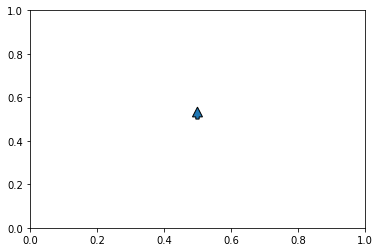

In [233]:
help(pplot.arrow)
pplot.arrow(0.5,0.5,0.0,0.01, width = 0.01,shape= "full")

In [4]:
# a whole experiment:
exp_idx = 2
d = get_dat(all_dat[exp_idx])
y = d['y']
X = d['X'][...,np.newaxis]
n = Node(X)
g = Graph([n],[])
vals = eval_graphnets(g.copy())

## Graph with two observations with a certain time interval between them:
dist_measurements = 20; # distance between measurements
spacing_readings = 1;
y2_0= d['y'][0:-dist_measurements:spacing_readings]
y2_1= d['y'][dist_measurements::spacing_readings]
X0 = d['X'][0:-dist_measurements:spacing_readings][..., np.newaxis]
X1 = d['X'][dist_measurements::spacing_readings][..., np.newaxis]
n0 = Node(X0)
n1 = Node(X1)
e01 = Edge(node_from = n0,node_to = n1, edge_attr_tensor=(y2_1 - y2_0)[:,np.newaxis])
g2 = Graph([n0,n1], [e01])
vals2 = eval_graphnets(g2.copy())


## Graph with three observations with a certain time interval between them:
dist_measurements = 20; # distance between measurements
spacing_readings = 1;
y2_0= d['y'][0:-dist_measurements:spacing_readings]
y2_1= d['y'][dist_measurements::spacing_readings]
X0 = d['X'][0:-dist_measurements:spacing_readings][..., np.newaxis]
X1 = d['X'][dist_measurements::spacing_readings][..., np.newaxis]
n0 = Node(X0)
n1 = Node(X1)
e01 = Edge(node_from = n0,node_to = n1, edge_attr_tensor=(y2_1 - y2_0)[:,np.newaxis])
g2 = Graph([n0,n1], [e01])
vals2 = eval_graphnets(g2.copy())

NameError: name 'get_dat' is not defined

In [5]:
pplot.plot(((latent[0]['latent_values'])/250)**2)
pplot.plot(((latent[2]['latent_values']/250))**2)
np.random.randn()


NameError: name 'pplot' is not defined

In [485]:
#graph_indep.graph_eval(g2.copy())
#graph_data_val[0].edges[0].edge_tensor.shape#e01.edge_tensor.shape


In [486]:

X0.shape,X1.shape

((208, 1000, 1), (208, 1000, 1))

AttributeError: 'numpy.ndarray' object has no attribute 'prob'

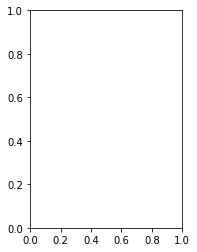

In [38]:
pplot.subplot(1,2,1)
#predictions_val[ids_sort.flatten()]
v = vals.prob(times).numpy().T
pplot.pcolor([r for r in range(v.shape[1])],times*350,v)
# pplot.yscale("log")
# pplot.semilogy(y,"C1")
pplot.plot(y, "C1")

pplot.subplot(1,2,2)
v = vals2.prob(times).numpy().T
pplot.pcolor([r for r in range(v.shape[1])],times*350,v)
#pplot.yscale("log")
#pplot.semilogy(y2_1,"C1")
pplot.plot(y2_1,"C1")


# Done. Success.